## Import libraries

In [192]:
import os
import labels
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Sampler, SubsetRandomSampler
from torch.utils.data import Dataset
from PIL import Image
from PIL import ImageFile
from torchvision import transforms
from tqdm import tqdm  # Import tqdm for progress visualization
from models.cnn_models import SimpleCNN
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  # If using a GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

## Define filepaths as constant

In [118]:
# Define file paths as constants
CSV_FILE_PATH = r'C:\Users\Sandhra George\avalanche\data\dataset.csv'
ROOT_DIR_PATH = r'C:\Users\Sandhra George\avalanche\caxton_dataset\print24'

csv_file = r'C:\Users\Sandhra George\avalanche\data\dataset.csv'  # Path to the CSV file
root_dir = r'C:\Users\Sandhra George\avalanche\caxton_dataset\print24'  # Path to the image directory

## Load data into DataFrame and filter print24

In [119]:
# Load data into a DataFrame for easier processing
data = pd.read_csv(CSV_FILE_PATH)

# Limit dataset to the images between row indices 454 and 7058 (inclusive)
#data_limited = data.iloc[454:7059].reset_index(drop=True)

# Filter the dataset to only include images containing "print24"
data_filtered = data[data.iloc[:, 0].str.contains('print24', na=False)]

# Update the first column to contain only the image filenames
data_filtered.iloc[:, 0] = data_filtered.iloc[:, 0].str.replace(r'.*?/(image-\d+\.jpg)', r'\1', regex=True)

# Display the updated DataFrame
print("First rows of filtered DataFrame:")
print(data_filtered.head())

# Display the last few rows of the updated DataFrame
print("\nLast rows of filtered DataFrame:")
print(data_filtered.tail())

First rows of filtered DataFrame:
          img_path               timestamp  flow_rate  feed_rate  z_offset  \
99496  image-4.jpg  2020-10-07T11:45:35-86        100        100       0.0   
99497  image-5.jpg  2020-10-07T11:45:36-32        100        100       0.0   
99498  image-6.jpg  2020-10-07T11:45:36-79        100        100       0.0   
99499  image-7.jpg  2020-10-07T11:45:37-26        100        100       0.0   
99500  image-8.jpg  2020-10-07T11:45:37-72        100        100       0.0   

       target_hotend  hotend    bed  nozzle_tip_x  nozzle_tip_y  img_num  \
99496          205.0  204.86  64.83           654           560        3   
99497          205.0  204.62  65.08           654           560        4   
99498          205.0  204.62  65.08           654           560        5   
99499          205.0  204.62  65.08           654           560        6   
99500          205.0  204.62  65.08           654           560        7   

       print_id  flow_rate_class  feed_r

## Analysing the target hotend temperature column

In [120]:
# Extract unique temperatures in the 'target_hotend' column and sort them
unique_temperatures = sorted(data_filtered['target_hotend'].unique())  # Sort temperatures in ascending order

# Calculate the full range of temperatures (min and max)
temperature_min = data_filtered['target_hotend'].min()
temperature_max = data_filtered['target_hotend'].max()

# Print the unique temperatures (sorted), count, and full range
print("\nUnique target hotend temperatures in the dataset (sorted):")
print(unique_temperatures)
print(f"\nNumber of unique target hotend temperatures: {len(unique_temperatures)}")
print(f"Temperature range: {temperature_min}° to {temperature_max}°")


Unique target hotend temperatures in the dataset (sorted):
[180.0, 181.0, 182.0, 183.0, 184.0, 185.0, 186.0, 187.0, 188.0, 189.0, 190.0, 191.0, 192.0, 193.0, 194.0, 195.0, 196.0, 197.0, 198.0, 199.0, 200.0, 201.0, 202.0, 203.0, 204.0, 205.0, 206.0, 207.0, 208.0, 209.0, 210.0, 211.0, 212.0, 213.0, 214.0, 215.0, 216.0, 217.0, 218.0, 219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 225.0, 226.0, 227.0, 228.0, 229.0, 230.0]

Number of unique target hotend temperatures: 51
Temperature range: 180.0° to 230.0°


## Create a random temperature sub list

In [121]:
# Check if we have enough unique temperatures to select from
if len(unique_temperatures) >= 50:
    # Select the lowest and highest temperatures
    temperature_sublist = [temperature_min, temperature_max]

    # Remove the lowest and highest temperatures from the unique temperatures list
    remaining_temperatures = [temp for temp in unique_temperatures if temp != temperature_min and temp != temperature_max]

    # Randomly select 40 other temperatures from the remaining ones
    random_temperatures = random.sample(remaining_temperatures, 40)

    # Add the random temperatures to the temperature_sublist
    temperature_sublist.extend(random_temperatures)
    
    # Sort from lowest to highest hotend temperature
    temperature_sublist = sorted(temperature_sublist)

    # Print the temperature sublist
    print("\nTemperature sublist:")
    print(temperature_sublist)
else:
    print("Not enough unique temperatures to select from. At least 40 unique temperatures are required.")


Temperature sublist:
[180.0, 181.0, 182.0, 183.0, 184.0, 186.0, 187.0, 188.0, 189.0, 191.0, 193.0, 194.0, 195.0, 196.0, 197.0, 198.0, 199.0, 201.0, 202.0, 203.0, 205.0, 208.0, 209.0, 211.0, 212.0, 213.0, 214.0, 215.0, 216.0, 217.0, 218.0, 219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 226.0, 227.0, 228.0, 229.0, 230.0]


## Create a new dataframe with equal class distribution

In [122]:
# Initialise a dictionary to store DataFrames for each class
class_datasets = {}

# Iterate through the filtered dataset to gather class-wise data
for class_id in [0, 1, 2]:  # Ensure we process all classes: 0, 1, 2
    # Filter the data for the current class
    class_data = data_filtered[data_filtered['hotend_class'] == class_id]
    
    if class_data.empty:
        print(f"Class {class_id} dataset size: 0")
    else:
        # Store the data for each class in the dictionary
        class_datasets[class_id] = class_data
        print(f"Class {class_id} dataset size: {len(class_data)}")

# Find the class with the fewest images
min_class_size = min(len(class_datasets[class_id]) for class_id in class_datasets)

# Print the class with the fewest images
print(f"\nSmallest class size: {min_class_size}")

# Now, we will sample the same number of images from each class
balanced_data = []

# Iterate over each class and sample min_class_size images
for class_id in class_datasets:
    class_data = class_datasets[class_id]
    
    # Randomly sample 'min_class_size' images from the class data
    sampled_class_data = class_data.sample(n=min_class_size, random_state=42)
    balanced_data.append(sampled_class_data)

# Combine all the sampled class data into one DataFrame
balanced_dataset = pd.concat(balanced_data).reset_index(drop=True)

# Display the balanced dataset summary
print(f"\nBalanced dataset size: {len(balanced_dataset)}")

# OPTIONAL: Shuffle the final balanced dataset
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first and last five rows of the shuffled dataset
print("\nFirst five rows of the shuffled balanced dataset:")
print(balanced_dataset.head())

print("\nLast five rows of the shuffled balanced dataset:")
print(balanced_dataset.tail())

# Print the count of images in each class after balancing
print("\nNumber of images in each hotend class in the balanced dataset:")
for class_id in [0, 1, 2]:
    class_count = len(balanced_dataset[balanced_dataset['hotend_class'] == class_id])
    print(f"Class {class_id}: {class_count} images")

Class 0 dataset size: 7424
Class 1 dataset size: 11232
Class 2 dataset size: 2492

Smallest class size: 2492

Balanced dataset size: 7476

First five rows of the shuffled balanced dataset:
          img_path               timestamp  flow_rate  feed_rate  z_offset  \
0  image-19089.jpg  2020-10-07T14:13:14-93        148         90      0.03   
1  image-10323.jpg  2020-10-07T13:05:32-49         92        197      0.04   
2   image-3170.jpg  2020-10-07T12:10:07-87         84        151      0.26   
3   image-2130.jpg  2020-10-07T12:02:04-56         75         55      0.00   
4   image-6277.jpg  2020-10-07T12:34:12-00        134         63      0.20   

   target_hotend  hotend    bed  nozzle_tip_x  nozzle_tip_y  img_num  \
0          185.0  185.44  65.28           654           560    19088   
1          206.0  206.25  65.06           654           560    10322   
2          182.0  188.05  65.05           654           560     3169   
3          187.0  187.08  64.92           654         

## Convert balanced_dataset into a dataframe that contains only the img_path and hotend_class

In [124]:
# Assuming the previous steps for balancing the dataset are already done...

# Select only the 'img_path' and 'hotend_class' columns
balanced_dataset_filtered = balanced_dataset[['img_path', 'hotend_class']]

# Display the first few rows of the filtered DataFrame
print("\nFirst five rows of the filtered balanced dataset:")
print(balanced_dataset_filtered.head())

# Display the last few rows of the filtered DataFrame
print("\nLast five rows of the filtered balanced dataset:")
print(balanced_dataset_filtered.tail())

# Optionally, if you want to save this filtered DataFrame to a CSV
#balanced_dataset_filtered.to_csv('balanced_dataset_filtered.csv', index=False)


First five rows of the filtered balanced dataset:
          img_path  hotend_class
0  image-19089.jpg             0
1  image-10323.jpg             1
2   image-3170.jpg             0
3   image-2130.jpg             0
4   image-6277.jpg             0

Last five rows of the filtered balanced dataset:
             img_path  hotend_class
7471   image-8380.jpg             2
7472   image-1401.jpg             2
7473  image-12102.jpg             2
7474   image-3722.jpg             0
7475  image-20837.jpg             2


In [125]:
# Check class distribution in balanced_dataset
class_distribution = balanced_dataset_filtered['hotend_class'].value_counts()
print(class_distribution)

hotend_class
0    2492
1    2492
2    2492
Name: count, dtype: int64


In [195]:
# Print the indices, the classes, and the number of images in each class
for class_label in class_distribution.index:
    # Get all indices for the current class
    class_indices = balanced_dataset_filtered[balanced_dataset_filtered['hotend_class'] == class_label].index.tolist()
    
    # Count the number of images for the current class
    num_images_in_class = len(class_indices)
    
    # Print the details for this class
    print(f"\nClass: {class_label} (Total images: {num_images_in_class})")
    print("Indices: ", class_indices)
    print(f"Number of images in class {class_label}: {num_images_in_class}")

# Step 1: Get the number of unique classes
num_classes = len(class_distribution)

# Step 2: Set a small batch size
small_batch_size = 15  # You can change this to a value like 32, 64, etc.

# Step 3: Calculate the number of samples per class per batch
samples_per_class = small_batch_size // num_classes  # Ensure it's divisible

# Make sure we don't ask for more samples than available in the smallest class
samples_per_class = min(samples_per_class, class_distribution.min())

# Step 4: Calculate the total batch size
batch_size = samples_per_class * num_classes

print(f"\nRecommended Small Batch Size: {batch_size}")
print(f"Samples per class: {samples_per_class}")


Class: 0 (Total images: 2492)
Indices:  [0, 2, 3, 4, 5, 6, 9, 10, 14, 16, 18, 20, 25, 27, 30, 32, 35, 38, 44, 45, 53, 54, 56, 61, 63, 64, 66, 67, 70, 71, 72, 74, 77, 78, 83, 85, 90, 93, 94, 100, 101, 110, 111, 113, 116, 117, 118, 120, 123, 124, 127, 128, 129, 130, 134, 139, 140, 146, 149, 151, 152, 157, 159, 161, 166, 167, 172, 174, 175, 176, 179, 186, 191, 196, 200, 204, 211, 218, 219, 225, 226, 227, 230, 234, 238, 239, 242, 243, 247, 249, 252, 254, 255, 261, 262, 266, 268, 270, 271, 272, 273, 276, 278, 279, 283, 286, 288, 290, 293, 298, 303, 305, 310, 316, 317, 318, 319, 320, 324, 327, 329, 331, 333, 334, 335, 340, 343, 344, 345, 347, 350, 352, 354, 356, 357, 361, 366, 371, 375, 377, 378, 380, 387, 391, 392, 393, 394, 396, 399, 403, 408, 409, 416, 425, 430, 434, 439, 440, 443, 446, 453, 456, 462, 465, 467, 471, 475, 477, 478, 479, 481, 482, 483, 485, 489, 490, 491, 493, 495, 496, 497, 501, 503, 504, 506, 508, 511, 513, 514, 515, 519, 523, 524, 526, 530, 533, 538, 539, 540, 545, 547,

## At this point the balanced dataset has been created

## Create training, validation, and testing datasets

In [196]:
# Number of images in each class (this will be the same after balancing)
num_images_per_class = len(balanced_dataset_filtered) // 3  # since there are 3 classes

# Calculate the number of samples per class
train_size = int(0.8 * num_images_per_class)
valid_size = int(0.1 * num_images_per_class)
test_size = num_images_per_class - train_size - valid_size

# Sample indices for each class
train_indices = []
valid_indices = []
test_indices = []

for class_label in [0, 1, 2]:
    class_data = balanced_dataset_filtered[balanced_dataset_filtered['hotend_class'] == class_label].index.tolist()
    
    # Shuffle the indices of the current class
    random.shuffle(class_data)
    
    # Split the indices for each class into train, validation, and test
    train_indices.extend(class_data[:train_size])
    valid_indices.extend(class_data[train_size:train_size + valid_size])
    test_indices.extend(class_data[train_size + valid_size:])

# Sort the indices of the training, validation, and test datasets to ensure consistent and ordered processing
train_indices = sorted(train_indices)
valid_indices = sorted(valid_indices)
test_indices = sorted(test_indices)

# Class distribution in train, validation, and test sets
train_class_distribution = [0, 0, 0]
valid_class_distribution = [0, 0, 0]
test_class_distribution = [0, 0, 0]

for index in train_indices:
    class_label = balanced_dataset_filtered.loc[index, 'hotend_class']
    train_class_distribution[class_label] += 1

for index in valid_indices:
    class_label = balanced_dataset_filtered.loc[index, 'hotend_class']
    valid_class_distribution[class_label] += 1

for index in test_indices:
    class_label = balanced_dataset_filtered.loc[index, 'hotend_class']
    test_class_distribution[class_label] += 1

# Print the class distribution
print("Train set class distribution:", train_class_distribution)
print("Validation set class distribution:", valid_class_distribution)
print("Test set class distribution:", test_class_distribution)

# Verify lengths
print("Train set size:", len(train_indices))
print("Validation set size:", len(valid_indices))
print("Test set size:", len(test_indices))

Train set class distribution: [1993, 1993, 1993]
Validation set class distribution: [249, 249, 249]
Test set class distribution: [250, 250, 250]
Train set size: 5979
Validation set size: 747
Test set size: 750


In [156]:
# Create DataFrames for train, validation, and test sets based on the indices
train_data = balanced_dataset_filtered.iloc[train_indices].reset_index(drop=True)
val_data = balanced_dataset_filtered.iloc[valid_indices].reset_index(drop=True)
test_data = balanced_dataset_filtered.iloc[test_indices].reset_index(drop=True)

# Optionally print the first few rows to verify
print("Train DataFrame sample:")
print(train_data.head())

print("Validation DataFrame sample:")
print(val_data.head())

print("Test DataFrame sample:")
print(test_data.head())

Train DataFrame sample:
          img_path  hotend_class
0  image-19089.jpg             0
1  image-10323.jpg             1
2   image-6277.jpg             0
3  image-19945.jpg             0
4  image-16946.jpg             0
Validation DataFrame sample:
          img_path  hotend_class
0   image-3170.jpg             0
1   image-4689.jpg             0
2   image-1677.jpg             2
3   image-1688.jpg             2
4  image-13683.jpg             0
Test DataFrame sample:
          img_path  hotend_class
0   image-2130.jpg             0
1  image-19192.jpg             0
2  image-20143.jpg             0
3  image-22545.jpg             1
4  image-23153.jpg             1


## Check for Missing or Invalid Labels in Training, Validation, and Test Data

In [168]:
# Check for any missing labels or invalid labels
print(train_data['hotend_class'].isnull().sum())  # Count missing labels
print(train_data['hotend_class'].unique())  # Check unique labels to ensure there are no unexpected values

# Check for any missing labels or invalid labels
print(val_data['hotend_class'].isnull().sum())  # Count missing labels
print(val_data['hotend_class'].unique())  # Check unique labels to ensure there are no unexpected values
# Check for any missing labels or invalid labels
print(test_data['hotend_class'].isnull().sum())  # Count missing labels
print(test_data['hotend_class'].unique())  # Check unique labels to ensure there are no unexpected values

0
[0 1 2]
0
[0 2 1]
0
[0 1 2]


## Balanced Dataset class

In [169]:
# Define the dataset class
class BalancedDataset(Dataset):
    def __init__(self, data_frame, root_dir, transform=None):
        self.data = data_frame
        self.root_dir = root_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Validate that the images exist in the directory
        self.valid_indices = self.get_valid_indices()

    def get_valid_indices(self):
        valid_indices = []
        for idx in tqdm(range(len(self.data)), desc="Validating images"):
            img_name = self.data.iloc[idx, 0].strip()
            img_name = img_name.split('/')[-1]  # Extract file name
            
            if img_name.startswith("image-"):
                try:
                    # Ensure we only include images in the valid range
                    image_number = int(img_name.split('-')[1].split('.')[0])
                    if 4 <= image_number <= 26637:
                        full_img_path = os.path.join(self.root_dir, img_name)
                        if os.path.exists(full_img_path):
                            valid_indices.append(idx)
                        else:
                            print(f"Image does not exist: {full_img_path}")
                except ValueError:
                    print(f"Invalid filename format for {img_name}. Skipping...")
        
        print(f"Total valid indices found: {len(valid_indices)}")  # Debugging output
        return valid_indices

    def __len__(self):
            return len(self.valid_indices)
    
    def __getitem__(self, idx):
        # Wrap around the index if it exceeds the length of valid indices
        idx = idx % len(self.valid_indices)
        
        # Get the actual index from valid indices
        actual_idx = self.valid_indices[idx]
        img_name = self.data.iloc[actual_idx, 0].strip()
        full_img_path = os.path.join(self.root_dir, img_name)
    
        try:
            # Attempt to open the image and convert to RGB
            image = Image.open(full_img_path).convert('RGB')
    
            # Fetch the label and convert it to an integer
            label_str = self.data.iloc[actual_idx]['hotend_class']  # Use column name 'hotend_class'
            label = int(label_str)  # Ensure label is integer
    
            # Apply transformations if defined
            if self.transform:
                image = self.transform(image)
    
            return image, label, actual_idx
        except (OSError, IOError, ValueError) as e:
            # Print error message for debugging
            print(f"Error loading image {full_img_path}: {e}")
    
            # Handle gracefully by skipping the corrupted/missing file
            # Fetch the next valid index (recursively handle until a valid image is found)
            return self.__getitem__((idx + 1) % len(self.valid_indices))

## Balanced Batch Sampler class

In [170]:
class BalancedBatchSampler(Sampler):
    def __init__(self, data_frame, batch_size=15, samples_per_class=5):
        """
        data_frame: Pandas DataFrame with image paths and their respective class labels.
        batch_size: Total batch size.
        samples_per_class: Number of samples to draw from each class per batch.
        """
        self.data_frame = data_frame
        self.batch_size = batch_size
        self.samples_per_class = samples_per_class
        self.num_classes = len(data_frame['hotend_class'].unique())
        
        if self.batch_size % self.num_classes != 0:
            raise ValueError("Batch size must be divisible by the number of classes.")

        self.class_indices = {
            class_id: self.data_frame[self.data_frame['hotend_class'] == class_id].index.tolist()
            for class_id in self.data_frame['hotend_class'].unique()
        }
        
        # Shuffle class indices initially
        for class_id in self.class_indices:
            random.shuffle(self.class_indices[class_id])

        self.num_samples_per_epoch = sum(len(indices) for indices in self.class_indices.values())
        self.indices_used = {class_id: [] for class_id in self.class_indices}

    def __iter__(self):
        batches = []

        # Replenish indices for each class
        for class_id in self.class_indices:
            if not self.class_indices[class_id]:
                raise ValueError(f"Class {class_id} has no samples. Cannot form balanced batches.")

            # Shuffle and use all indices from this class
            self.indices_used[class_id] = self.class_indices[class_id].copy()
            random.shuffle(self.indices_used[class_id])

        # Generate balanced batches
        while len(batches) * self.batch_size < self.num_samples_per_epoch:
            batch = []
            for class_id in self.indices_used:
                if len(self.indices_used[class_id]) < self.samples_per_class:
                    # If a class runs out of samples, reshuffle and replenish
                    self.indices_used[class_id] = self.class_indices[class_id].copy()
                    random.shuffle(self.indices_used[class_id])

                # Take `samples_per_class` indices from the current class
                batch.extend(self.indices_used[class_id][:self.samples_per_class])
                self.indices_used[class_id] = self.indices_used[class_id][self.samples_per_class:]

            # Shuffle the batch and append
            random.shuffle(batch)
            batches.append(batch)

        return iter(batches)

    def __len__(self):
        # Total number of batches per epoch
        return self.num_samples_per_epoch // self.batch_size

In [184]:
# Create the dataset instance (make sure to provide the right data_frame and root directory)
train_dataset = BalancedDataset(data_frame=train_data, root_dir=root_dir)
val_dataset = BalancedDataset(data_frame=val_data, root_dir=root_dir)
test_dataset = BalancedDataset(data_frame=test_data, root_dir=root_dir)

# Create the sampler (pass the DataFrame instead of the dataset)
train_sampler = BalancedBatchSampler(data_frame=train_data, batch_size=15, samples_per_class=5)
val_sampler = BalancedBatchSampler(data_frame=val_data, batch_size=15, samples_per_class=5)
test_sampler = BalancedBatchSampler(data_frame=test_data, batch_size=15, samples_per_class=5)

# Create the DataLoader with the sampler
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, shuffle = False)

# For validation and testing, we typically don't need a batch_sampler, so use regular batching
val_loader = DataLoader(val_dataset, batch_sampler=val_sampler, shuffle = False)  # or any batch size that makes sense
test_loader = DataLoader(test_dataset, batch_sampler=test_sampler)  # same as above

print(f"Train dataset length: {len(train_loader.dataset)}")
print(f"Validation dataset length: {len(val_loader.dataset)}")
print(f"Test dataset length: {len(test_loader.dataset)}")

Validating images: 100%|██████████| 5979/5979 [00:00<00:00, 13764.91it/s]


Total valid indices found: 5979


Validating images: 100%|██████████| 747/747 [00:00<00:00, 11565.18it/s]


Total valid indices found: 747


Validating images: 100%|██████████| 750/750 [00:00<00:00, 9992.53it/s]

Total valid indices found: 750
Train dataset length: 5979
Validation dataset length: 747
Test dataset length: 750


## Check the class distribution of randomly selected batches in train loader

In [172]:
# Function to print random batches and their class distribution
def print_random_batches(train_loader, num_batches=5):
    for _ in range(num_batches):
        # Get the next batch from the loader
        batch_images, batch_labels, _ = next(iter(train_loader))  # Get the images, labels, and indices (if needed)
        
        # Calculate the class distribution in this batch
        class_distribution = Counter(batch_labels.tolist())  # Convert tensor to list for counting
        
        # Print the class distribution for the current batch
        print(f"Class distribution for this batch: {dict(class_distribution)}")
        
        # Print the actual labels for the batch (as a list or tensor)
        print("Actual labels for this batch:")
        print(batch_labels.tolist())  # Converts tensor to list for readability
        
        # Print the image tensor shape for the batch
        print("Image tensor shape for the batch:")
        print(batch_images.shape)  # This prints the shape of the image tensor
        
        # Optionally, print a few details of the image tensors (e.g., min and max values) to understand them
        print("Min and max values of the image tensors:")
        print(f"Min: {batch_images.min()}, Max: {batch_images.max()}")
        
        # If you want to print the image itself (assuming it's a small size, for visualization)
        # You can use something like matplotlib to visualize the images, for example:
        # from matplotlib import pyplot as plt
        # plt.imshow(batch_images[0].permute(1, 2, 0).numpy())  # assuming 3 channel images
        # plt.show()
        
        print("-" * 50)

# Print random batches and their class distribution
print_random_batches(train_loader, num_batches=5)

Class distribution for this batch: {2: 5, 1: 5, 0: 5}
Actual labels for this batch:
[2, 1, 0, 0, 2, 0, 2, 1, 0, 2, 1, 1, 1, 2, 0]
Image tensor shape for the batch:
torch.Size([15, 3, 224, 224])
Min and max values of the image tensors:
Min: -2.015155553817749, Max: 2.640000104904175
--------------------------------------------------
Class distribution for this batch: {2: 5, 0: 5, 1: 5}
Actual labels for this batch:
[2, 0, 2, 2, 1, 2, 1, 0, 0, 1, 0, 2, 1, 1, 0]
Image tensor shape for the batch:
torch.Size([15, 3, 224, 224])
Min and max values of the image tensors:
Min: -2.1179039478302, Max: 2.640000104904175
--------------------------------------------------
Class distribution for this batch: {1: 5, 2: 5, 0: 5}
Actual labels for this batch:
[1, 2, 0, 2, 1, 0, 2, 0, 2, 0, 2, 1, 1, 1, 0]
Image tensor shape for the batch:
torch.Size([15, 3, 224, 224])
Min and max values of the image tensors:
Min: -2.0665297508239746, Max: 2.640000104904175
--------------------------------------------------

## Check class distribution of random batches from training, validation and testing data

In [173]:
def print_label_batch_from_loader(loader, dataset_name):
    """Fetch and print a batch of labels from the data loader."""
    data_iter = iter(loader)
    batch_images, batch_labels, _ = next(data_iter)  # Get one batch (including the index)
    
    print(f"\n{dataset_name} - Sample Label Batch:")
    print(batch_labels)  # Print the labels for the batch
    
    # Optionally, you can convert the tensor labels to a list for easier reading:
    print(f"Labels as list: {batch_labels.tolist()}")

# Print batches of labels from the train, validation, and test loaders
print_label_batch_from_loader(train_loader, 'Training')
print_label_batch_from_loader(val_loader, 'Validation')
print_label_batch_from_loader(test_loader, 'Test')


Training - Sample Label Batch:
tensor([0, 1, 0, 0, 0, 1, 0, 2, 1, 2, 2, 1, 2, 2, 1])
Labels as list: [0, 1, 0, 0, 0, 1, 0, 2, 1, 2, 2, 1, 2, 2, 1]

Validation - Sample Label Batch:
tensor([0, 1, 1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 0, 2, 2])
Labels as list: [0, 1, 1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 0, 2, 2]

Test - Sample Label Batch:
tensor([0, 0, 1, 1, 2, 0, 2, 1, 2, 0, 1, 2, 2, 1, 0])
Labels as list: [0, 0, 1, 1, 2, 0, 2, 1, 2, 0, 1, 2, 2, 1, 0]


## Display a Random Image from the Dataset with Its Label

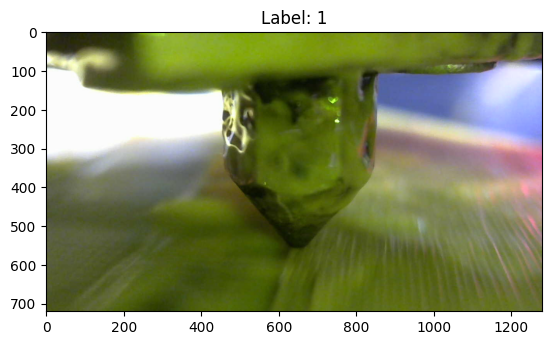

C:\Users\Sandhra George\avalanche\caxton_dataset\print24\image-2261.jpg
C:\Users\Sandhra George\avalanche\caxton_dataset\print24\image-2261.jpg


In [174]:
import matplotlib.pyplot as plt
import random

# Assume 'train_data' is your DataFrame with image paths and labels
random_index = random.choice(train_data.index)  # Choose a random index
img_path = os.path.join(root_dir, train_data.iloc[random_index, 0])
label = train_data.loc[random_index, 'hotend_class']

# Load the image
img = plt.imread(img_path)  # Use appropriate image loading method

# Plot the image and display the label
plt.imshow(img)
plt.title(f"Label: {label}")
plt.show()
print(img_path)
print(img_path)

In [180]:
# Ensure that image paths and labels are correctly aligned

# First image
first_index = train_data.index[0]
first_image = train_data.loc[first_index, 'img_path']
first_label = train_data.loc[first_index, 'hotend_class']
print(f"First Image Path: {first_image}, First Label: {first_label}")

# Last image
last_index = train_data.index[-1]  # Accessing the last index
last_image = train_data.loc[last_index, 'img_path']
last_label = train_data.loc[last_index, 'hotend_class']
print(f"Last Image Path: {last_image}, Last Label: {last_label}")


First Image Path: image-19089.jpg, First Label: 0
Last Image Path: image-20837.jpg, Last Label: 2


## Printing Class Distribution for Training, Validation, and Test Data

In [193]:
# Function to print class distribution
def print_class_distribution(loader, dataset_name):
    """Print class distribution in the dataset."""
    all_labels = []

    # Collect all labels from the dataset
    for batch in loader:
        if len(batch) == 2:  # Normal batch with (image, label)
            _, labels = batch
        elif len(batch) == 3:  # Batch with (image, label, idx) from BalancedDataset
            _, labels, _ = batch
        
        # Collect labels from the batch
        all_labels.extend(labels.cpu().numpy())  # Collect labels and move them to CPU if using GPU

    # Calculate and print the class distribution
    class_counts = Counter(all_labels)
    print(f"\n{dataset_name} Class Distribution:")
    for class_id, count in class_counts.items():
        print(f"Class {class_id}: {count} samples")

# Print class distribution for train, validation, and test data
print_class_distribution(train_loader, 'Training')
print_class_distribution(val_loader, 'Validation')
print_class_distribution(test_loader, 'Test')


Training Class Distribution:
Class 0: 1995 samples
Class 2: 1995 samples
Class 1: 1995 samples

Validation Class Distribution:
Class 0: 250 samples
Class 1: 250 samples
Class 2: 250 samples

Test Class Distribution:
Class 2: 250 samples
Class 1: 250 samples
Class 0: 250 samples


## Model Training, Validation, and Testing with Class Distribution and Learning Rate Scheduling


Epoch 1/2


Training:   0%|          | 1/398 [00:02<16:29,  2.49s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:   1%|          | 2/398 [00:04<13:16,  2.01s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2


Training:   1%|          | 3/398 [00:05<12:04,  1.83s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Training:   1%|          | 4/398 [00:07<11:25,  1.74s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0


Training:   1%|▏         | 5/398 [00:09<11:27,  1.75s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2


Training:   2%|▏         | 6/398 [00:10<10:56,  1.68s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:   2%|▏         | 7/398 [00:12<11:12,  1.72s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:   2%|▏         | 8/398 [00:13<10:42,  1.65s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:   2%|▏         | 9/398 [00:15<10:39,  1.64s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Training:   3%|▎         | 10/398 [00:17<10:36,  1.64s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:   3%|▎         | 11/398 [00:18<10:30,  1.63s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0


Training:   3%|▎         | 12/398 [00:20<10:14,  1.59s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:   3%|▎         | 13/398 [00:21<09:52,  1.54s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1


Training:   4%|▎         | 14/398 [00:23<09:53,  1.55s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0


Training:   4%|▍         | 15/398 [00:25<10:19,  1.62s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0


Training:   4%|▍         | 16/398 [00:26<10:21,  1.63s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1


Training:   4%|▍         | 17/398 [00:28<10:24,  1.64s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Training:   5%|▍         | 18/398 [00:29<10:08,  1.60s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:   5%|▍         | 19/398 [00:31<09:40,  1.53s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2


Training:   5%|▌         | 20/398 [00:32<09:52,  1.57s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:   5%|▌         | 21/398 [00:34<09:47,  1.56s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:   6%|▌         | 22/398 [00:36<09:54,  1.58s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:   6%|▌         | 23/398 [00:37<10:10,  1.63s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:   6%|▌         | 24/398 [00:39<09:59,  1.60s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


Training:   6%|▋         | 25/398 [00:41<09:55,  1.60s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:   7%|▋         | 26/398 [00:42<09:46,  1.58s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:   7%|▋         | 27/398 [00:44<09:46,  1.58s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0


Training:   7%|▋         | 28/398 [00:45<10:15,  1.66s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1


Training:   7%|▋         | 29/398 [00:47<10:21,  1.69s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0


Training:   8%|▊         | 30/398 [00:49<10:40,  1.74s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:   8%|▊         | 31/398 [00:51<10:35,  1.73s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:   8%|▊         | 32/398 [00:53<10:33,  1.73s/it]

Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:   8%|▊         | 33/398 [00:54<10:22,  1.71s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2


Training:   9%|▊         | 34/398 [00:56<10:12,  1.68s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:   9%|▉         | 35/398 [00:57<10:05,  1.67s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:   9%|▉         | 36/398 [00:59<10:04,  1.67s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:   9%|▉         | 37/398 [01:01<09:48,  1.63s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  10%|▉         | 38/398 [01:02<10:01,  1.67s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2


Training:  10%|▉         | 39/398 [01:05<11:07,  1.86s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  10%|█         | 40/398 [01:08<13:36,  2.28s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  10%|█         | 41/398 [01:10<12:51,  2.16s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  11%|█         | 42/398 [01:12<12:08,  2.05s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2


Training:  11%|█         | 43/398 [01:13<11:35,  1.96s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Training:  11%|█         | 44/398 [01:15<10:58,  1.86s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1


Training:  11%|█▏        | 45/398 [01:16<10:09,  1.73s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2


Training:  12%|█▏        | 46/398 [01:18<09:57,  1.70s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  12%|█▏        | 47/398 [01:20<09:47,  1.67s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0


Training:  12%|█▏        | 48/398 [01:21<09:40,  1.66s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  12%|█▏        | 49/398 [01:23<10:01,  1.72s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Training:  13%|█▎        | 50/398 [01:25<09:52,  1.70s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Training:  13%|█▎        | 51/398 [01:26<09:35,  1.66s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Training:  13%|█▎        | 52/398 [01:28<09:29,  1.65s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0


Training:  13%|█▎        | 53/398 [01:30<09:27,  1.65s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  14%|█▎        | 54/398 [01:31<09:06,  1.59s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1


Training:  14%|█▍        | 55/398 [01:32<08:39,  1.51s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2


Training:  14%|█▍        | 56/398 [01:34<08:46,  1.54s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0


Training:  14%|█▍        | 57/398 [01:36<08:55,  1.57s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  15%|█▍        | 58/398 [01:37<08:44,  1.54s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1


Training:  15%|█▍        | 59/398 [01:39<08:43,  1.54s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1


Training:  15%|█▌        | 60/398 [01:40<08:39,  1.54s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:  15%|█▌        | 61/398 [01:42<08:33,  1.53s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Training:  16%|█▌        | 62/398 [01:43<08:34,  1.53s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Training:  16%|█▌        | 63/398 [01:45<08:34,  1.54s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1


Training:  16%|█▌        | 64/398 [01:47<08:49,  1.58s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  16%|█▋        | 65/398 [01:48<08:48,  1.59s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


Training:  17%|█▋        | 66/398 [01:50<08:52,  1.60s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Training:  17%|█▋        | 67/398 [01:51<08:46,  1.59s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:  17%|█▋        | 68/398 [01:53<08:29,  1.54s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  17%|█▋        | 69/398 [01:54<08:39,  1.58s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Training:  18%|█▊        | 70/398 [01:56<08:32,  1.56s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  18%|█▊        | 71/398 [01:58<08:30,  1.56s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  18%|█▊        | 72/398 [01:59<08:33,  1.57s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Training:  18%|█▊        | 73/398 [02:01<08:24,  1.55s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  19%|█▊        | 74/398 [02:02<08:16,  1.53s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1


Training:  19%|█▉        | 75/398 [02:04<08:18,  1.54s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2


Training:  19%|█▉        | 76/398 [02:05<08:21,  1.56s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Training:  19%|█▉        | 77/398 [02:07<08:15,  1.54s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  20%|█▉        | 78/398 [02:08<08:11,  1.54s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


Training:  20%|█▉        | 79/398 [02:10<08:05,  1.52s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1


Training:  20%|██        | 80/398 [02:11<07:55,  1.49s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1


Training:  20%|██        | 81/398 [02:13<07:49,  1.48s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2


Training:  21%|██        | 82/398 [02:14<07:44,  1.47s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Training:  21%|██        | 83/398 [02:16<07:37,  1.45s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  21%|██        | 84/398 [02:17<07:33,  1.44s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Training:  21%|██▏       | 85/398 [02:19<07:52,  1.51s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  22%|██▏       | 86/398 [02:20<07:47,  1.50s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0


Training:  22%|██▏       | 87/398 [02:22<07:41,  1.48s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2


Training:  22%|██▏       | 88/398 [02:23<08:04,  1.56s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2


Training:  22%|██▏       | 89/398 [02:25<08:09,  1.58s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2


Training:  23%|██▎       | 90/398 [02:27<09:10,  1.79s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2


Training:  23%|██▎       | 91/398 [02:29<09:14,  1.80s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Training:  23%|██▎       | 92/398 [02:31<08:48,  1.73s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  23%|██▎       | 93/398 [02:32<08:21,  1.65s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Training:  24%|██▎       | 94/398 [02:34<08:06,  1.60s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2


Training:  24%|██▍       | 95/398 [02:35<07:57,  1.58s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Training:  24%|██▍       | 96/398 [02:36<07:41,  1.53s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0


Training:  24%|██▍       | 97/398 [02:38<07:43,  1.54s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Training:  25%|██▍       | 98/398 [02:39<07:34,  1.51s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0


Training:  25%|██▍       | 99/398 [02:41<07:21,  1.48s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1


Training:  25%|██▌       | 100/398 [02:42<07:24,  1.49s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  25%|██▌       | 101/398 [02:44<07:22,  1.49s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Training:  26%|██▌       | 102/398 [02:45<07:15,  1.47s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1


Training:  26%|██▌       | 103/398 [02:47<07:11,  1.46s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2


Training:  26%|██▌       | 104/398 [02:48<07:07,  1.45s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0


Training:  26%|██▋       | 105/398 [02:50<07:16,  1.49s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Training:  27%|██▋       | 106/398 [02:51<07:19,  1.50s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  27%|██▋       | 107/398 [02:53<07:11,  1.48s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2


Training:  27%|██▋       | 108/398 [02:54<07:22,  1.53s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1


Training:  27%|██▋       | 109/398 [02:56<07:23,  1.54s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  28%|██▊       | 110/398 [02:57<07:21,  1.53s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


Training:  28%|██▊       | 111/398 [02:59<07:41,  1.61s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Training:  28%|██▊       | 112/398 [03:01<07:31,  1.58s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0


Training:  28%|██▊       | 113/398 [03:02<07:28,  1.57s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1


Training:  29%|██▊       | 114/398 [03:04<07:36,  1.61s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1


Training:  29%|██▉       | 115/398 [03:05<07:17,  1.55s/it]

Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1


Training:  29%|██▉       | 116/398 [03:07<07:07,  1.52s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2


Training:  29%|██▉       | 117/398 [03:08<07:09,  1.53s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1


Training:  30%|██▉       | 118/398 [03:10<07:00,  1.50s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Training:  30%|██▉       | 119/398 [03:11<06:53,  1.48s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0


Training:  30%|███       | 120/398 [03:13<06:49,  1.47s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0


Training:  30%|███       | 121/398 [03:14<06:48,  1.48s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0


Training:  31%|███       | 122/398 [03:16<06:45,  1.47s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:  31%|███       | 123/398 [03:17<06:33,  1.43s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2


Training:  31%|███       | 124/398 [03:18<06:37,  1.45s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:  31%|███▏      | 125/398 [03:20<06:37,  1.46s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  32%|███▏      | 126/398 [03:21<06:33,  1.45s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  32%|███▏      | 127/398 [03:23<06:32,  1.45s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2


Training:  32%|███▏      | 128/398 [03:24<06:39,  1.48s/it]

Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1


Training:  32%|███▏      | 129/398 [03:26<06:44,  1.51s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0


Training:  33%|███▎      | 130/398 [03:28<06:50,  1.53s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2


Training:  33%|███▎      | 131/398 [03:29<06:55,  1.56s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2


Training:  33%|███▎      | 132/398 [03:31<06:53,  1.55s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Training:  33%|███▎      | 133/398 [03:32<06:47,  1.54s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1


Training:  34%|███▎      | 134/398 [03:34<06:49,  1.55s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2


Training:  34%|███▍      | 135/398 [03:35<06:41,  1.53s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1


Training:  34%|███▍      | 136/398 [03:37<06:37,  1.52s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1


Training:  34%|███▍      | 137/398 [03:39<06:57,  1.60s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Training:  35%|███▍      | 138/398 [03:40<07:03,  1.63s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2


Training:  35%|███▍      | 139/398 [03:42<06:47,  1.57s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1


Training:  35%|███▌      | 140/398 [03:43<06:43,  1.56s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0


Training:  35%|███▌      | 141/398 [03:45<06:43,  1.57s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1


Training:  36%|███▌      | 142/398 [03:46<06:30,  1.53s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  36%|███▌      | 143/398 [03:48<06:24,  1.51s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0


Training:  36%|███▌      | 144/398 [03:49<06:17,  1.48s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Training:  36%|███▋      | 145/398 [03:51<06:08,  1.45s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1


Training:  37%|███▋      | 146/398 [03:52<06:03,  1.44s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:  37%|███▋      | 147/398 [03:54<06:29,  1.55s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2


Training:  37%|███▋      | 148/398 [03:55<06:32,  1.57s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Training:  37%|███▋      | 149/398 [03:57<06:18,  1.52s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2


Training:  38%|███▊      | 150/398 [03:58<06:18,  1.52s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2


Training:  38%|███▊      | 151/398 [04:00<06:18,  1.53s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0


Training:  38%|███▊      | 152/398 [04:01<06:05,  1.49s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0


Training:  38%|███▊      | 153/398 [04:03<06:01,  1.47s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  39%|███▊      | 154/398 [04:04<05:55,  1.46s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0


Training:  39%|███▉      | 155/398 [04:06<05:53,  1.45s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2


Training:  39%|███▉      | 156/398 [04:07<05:45,  1.43s/it]

Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0


Training:  39%|███▉      | 157/398 [04:08<05:50,  1.45s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0


Training:  40%|███▉      | 158/398 [04:10<05:47,  1.45s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1


Training:  40%|███▉      | 159/398 [04:11<05:41,  1.43s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2


Training:  40%|████      | 160/398 [04:13<05:38,  1.42s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2


Training:  40%|████      | 161/398 [04:14<05:41,  1.44s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0


Training:  41%|████      | 162/398 [04:15<05:35,  1.42s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1


Training:  41%|████      | 163/398 [04:17<05:34,  1.42s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0


Training:  41%|████      | 164/398 [04:18<05:32,  1.42s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1


Training:  41%|████▏     | 165/398 [04:20<05:35,  1.44s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2


Training:  42%|████▏     | 166/398 [04:21<05:30,  1.42s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  42%|████▏     | 167/398 [04:23<05:29,  1.43s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2


Training:  42%|████▏     | 168/398 [04:24<05:33,  1.45s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2


Training:  42%|████▏     | 169/398 [04:26<05:28,  1.44s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:  43%|████▎     | 170/398 [04:27<05:22,  1.41s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  43%|████▎     | 171/398 [04:28<05:23,  1.43s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2


Training:  43%|████▎     | 172/398 [04:30<05:27,  1.45s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Training:  43%|████▎     | 173/398 [04:31<05:22,  1.43s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0


Training:  44%|████▎     | 174/398 [04:33<05:21,  1.44s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0


Training:  44%|████▍     | 175/398 [04:34<05:21,  1.44s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  44%|████▍     | 176/398 [04:36<05:17,  1.43s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2


Training:  44%|████▍     | 177/398 [04:37<05:11,  1.41s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1


Training:  45%|████▍     | 178/398 [04:38<05:16,  1.44s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2


Training:  45%|████▍     | 179/398 [04:40<05:14,  1.43s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  45%|████▌     | 180/398 [04:41<05:11,  1.43s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0


Training:  45%|████▌     | 181/398 [04:43<05:07,  1.42s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0


Training:  46%|████▌     | 182/398 [04:44<05:18,  1.48s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Training:  46%|████▌     | 183/398 [04:46<05:28,  1.53s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Training:  46%|████▌     | 184/398 [04:47<05:24,  1.52s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0


Training:  46%|████▋     | 185/398 [04:49<05:23,  1.52s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2


Training:  47%|████▋     | 186/398 [04:51<05:33,  1.57s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Training:  47%|████▋     | 187/398 [04:53<05:56,  1.69s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2


Training:  47%|████▋     | 188/398 [04:54<05:46,  1.65s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0


Training:  47%|████▋     | 189/398 [04:56<05:37,  1.62s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:  48%|████▊     | 190/398 [04:57<05:31,  1.59s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Training:  48%|████▊     | 191/398 [04:59<05:33,  1.61s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


Training:  48%|████▊     | 192/398 [05:00<05:25,  1.58s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0


Training:  48%|████▊     | 193/398 [05:02<05:17,  1.55s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Training:  49%|████▊     | 194/398 [05:03<05:15,  1.55s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0


Training:  49%|████▉     | 195/398 [05:05<05:22,  1.59s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2


Training:  49%|████▉     | 196/398 [05:07<05:21,  1.59s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1


Training:  49%|████▉     | 197/398 [05:08<05:23,  1.61s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  50%|████▉     | 198/398 [05:10<05:12,  1.56s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  50%|█████     | 199/398 [05:11<05:14,  1.58s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1


Training:  50%|█████     | 200/398 [05:13<05:07,  1.55s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0


Training:  51%|█████     | 201/398 [05:14<05:01,  1.53s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1


Training:  51%|█████     | 202/398 [05:16<04:53,  1.50s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2


Training:  51%|█████     | 203/398 [05:17<04:46,  1.47s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0


Training:  51%|█████▏    | 204/398 [05:19<04:47,  1.48s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2


Training:  52%|█████▏    | 205/398 [05:20<04:42,  1.47s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2


Training:  52%|█████▏    | 206/398 [05:22<04:40,  1.46s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Training:  52%|█████▏    | 207/398 [05:23<04:39,  1.47s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1


Training:  52%|█████▏    | 208/398 [05:25<04:39,  1.47s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0


Training:  53%|█████▎    | 209/398 [05:26<04:38,  1.47s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0


Training:  53%|█████▎    | 210/398 [05:27<04:34,  1.46s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1


Training:  53%|█████▎    | 211/398 [05:29<04:37,  1.48s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0


Training:  53%|█████▎    | 212/398 [05:30<04:31,  1.46s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0


Training:  54%|█████▎    | 213/398 [05:32<04:29,  1.46s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2


Training:  54%|█████▍    | 214/398 [05:33<04:30,  1.47s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Training:  54%|█████▍    | 215/398 [05:35<04:31,  1.48s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2


Training:  54%|█████▍    | 216/398 [05:37<04:42,  1.55s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1


Training:  55%|█████▍    | 217/398 [05:38<04:51,  1.61s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Training:  55%|█████▍    | 218/398 [05:40<04:43,  1.57s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2


Training:  55%|█████▌    | 219/398 [05:41<04:33,  1.53s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2


Training:  55%|█████▌    | 220/398 [05:43<04:26,  1.49s/it]

Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1


Training:  56%|█████▌    | 221/398 [05:44<04:25,  1.50s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1


Training:  56%|█████▌    | 222/398 [05:46<04:19,  1.47s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Training:  56%|█████▌    | 223/398 [05:47<04:17,  1.47s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Training:  56%|█████▋    | 224/398 [05:49<04:18,  1.49s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2


Training:  57%|█████▋    | 225/398 [05:50<04:17,  1.49s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1


Training:  57%|█████▋    | 226/398 [05:52<04:12,  1.47s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1


Training:  57%|█████▋    | 227/398 [05:53<04:14,  1.49s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Training:  57%|█████▋    | 228/398 [05:55<04:12,  1.48s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2


Training:  58%|█████▊    | 229/398 [05:56<04:16,  1.52s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2


Training:  58%|█████▊    | 230/398 [05:58<04:14,  1.51s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Training:  58%|█████▊    | 231/398 [05:59<04:13,  1.52s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2


Training:  58%|█████▊    | 232/398 [06:01<04:07,  1.49s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:  59%|█████▊    | 233/398 [06:02<04:03,  1.48s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1


Training:  59%|█████▉    | 234/398 [06:04<04:05,  1.50s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0


Training:  59%|█████▉    | 235/398 [06:05<04:01,  1.48s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1


Training:  59%|█████▉    | 236/398 [06:06<03:59,  1.48s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2


Training:  60%|█████▉    | 237/398 [06:08<03:59,  1.49s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Training:  60%|█████▉    | 238/398 [06:10<04:02,  1.52s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0


Training:  60%|██████    | 239/398 [06:11<04:03,  1.53s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0


Training:  60%|██████    | 240/398 [06:13<04:00,  1.52s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Training:  61%|██████    | 241/398 [06:14<04:04,  1.56s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0


Training:  61%|██████    | 242/398 [06:16<03:56,  1.51s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0


Training:  61%|██████    | 243/398 [06:18<04:12,  1.63s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  61%|██████▏   | 244/398 [06:19<04:05,  1.60s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:  62%|██████▏   | 245/398 [06:21<03:56,  1.55s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Training:  62%|██████▏   | 246/398 [06:22<03:52,  1.53s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1


Training:  62%|██████▏   | 247/398 [06:24<03:54,  1.55s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1


Training:  62%|██████▏   | 248/398 [06:25<03:49,  1.53s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0


Training:  63%|██████▎   | 249/398 [06:27<03:49,  1.54s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Training:  63%|██████▎   | 250/398 [06:28<03:44,  1.52s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0


Training:  63%|██████▎   | 251/398 [06:30<03:39,  1.50s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1


Training:  63%|██████▎   | 252/398 [06:31<03:37,  1.49s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1


Training:  64%|██████▎   | 253/398 [06:32<03:31,  1.46s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0


Training:  64%|██████▍   | 254/398 [06:34<03:38,  1.52s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Training:  64%|██████▍   | 255/398 [06:36<03:40,  1.54s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1


Training:  64%|██████▍   | 256/398 [06:37<03:38,  1.54s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Training:  65%|██████▍   | 257/398 [06:39<03:41,  1.57s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2


Training:  65%|██████▍   | 258/398 [06:40<03:38,  1.56s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1


Training:  65%|██████▌   | 259/398 [06:42<03:38,  1.57s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1


Training:  65%|██████▌   | 260/398 [06:44<03:37,  1.58s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0


Training:  66%|██████▌   | 261/398 [06:45<03:33,  1.56s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  66%|██████▌   | 262/398 [06:47<03:43,  1.64s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  66%|██████▌   | 263/398 [06:49<04:06,  1.82s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0


Training:  66%|██████▋   | 264/398 [06:51<03:46,  1.69s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2


Training:  67%|██████▋   | 265/398 [06:52<03:37,  1.64s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1


Training:  67%|██████▋   | 266/398 [06:54<03:30,  1.60s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:  67%|██████▋   | 267/398 [06:55<03:27,  1.58s/it]

Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2


Training:  67%|██████▋   | 268/398 [06:57<03:24,  1.58s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2


Training:  68%|██████▊   | 269/398 [06:58<03:19,  1.54s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1


Training:  68%|██████▊   | 270/398 [07:00<03:13,  1.52s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1


Training:  68%|██████▊   | 271/398 [07:01<03:08,  1.48s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2


Training:  68%|██████▊   | 272/398 [07:02<03:02,  1.45s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0


Training:  69%|██████▊   | 273/398 [07:04<03:04,  1.48s/it]

Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  69%|██████▉   | 274/398 [07:05<03:01,  1.46s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:  69%|██████▉   | 275/398 [07:07<02:57,  1.45s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2


Training:  69%|██████▉   | 276/398 [07:08<03:02,  1.49s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2


Training:  70%|██████▉   | 277/398 [07:10<03:10,  1.57s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2


Training:  70%|██████▉   | 278/398 [07:12<03:08,  1.57s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2


Training:  70%|███████   | 279/398 [07:13<03:06,  1.56s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0


Training:  70%|███████   | 280/398 [07:15<03:04,  1.56s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0


Training:  71%|███████   | 281/398 [07:16<03:05,  1.59s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0


Training:  71%|███████   | 282/398 [07:18<03:08,  1.63s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1


Training:  71%|███████   | 283/398 [07:20<03:07,  1.63s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0


Training:  71%|███████▏  | 284/398 [07:21<02:59,  1.58s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  72%|███████▏  | 285/398 [07:23<02:54,  1.54s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0


Training:  72%|███████▏  | 286/398 [07:24<02:54,  1.56s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Training:  72%|███████▏  | 287/398 [07:26<02:49,  1.53s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2


Training:  72%|███████▏  | 288/398 [07:27<02:44,  1.50s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0


Training:  73%|███████▎  | 289/398 [07:29<02:46,  1.53s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Training:  73%|███████▎  | 290/398 [07:30<02:42,  1.50s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  73%|███████▎  | 291/398 [07:32<02:38,  1.48s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2


Training:  73%|███████▎  | 292/398 [07:33<02:39,  1.50s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:  74%|███████▎  | 293/398 [07:35<02:38,  1.51s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  74%|███████▍  | 294/398 [07:36<02:34,  1.48s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0


Training:  74%|███████▍  | 295/398 [07:38<02:33,  1.49s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:  74%|███████▍  | 296/398 [07:39<02:33,  1.51s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2


Training:  75%|███████▍  | 297/398 [07:41<02:28,  1.47s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2


Training:  75%|███████▍  | 298/398 [07:42<02:28,  1.49s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0


Training:  75%|███████▌  | 299/398 [07:44<02:30,  1.52s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2


Training:  75%|███████▌  | 300/398 [07:46<02:42,  1.66s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0


Training:  76%|███████▌  | 301/398 [07:47<02:36,  1.61s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Training:  76%|███████▌  | 302/398 [07:49<02:31,  1.58s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Training:  76%|███████▌  | 303/398 [07:50<02:26,  1.54s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1


Training:  76%|███████▋  | 304/398 [07:52<02:21,  1.50s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Training:  77%|███████▋  | 305/398 [07:53<02:19,  1.50s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1


Training:  77%|███████▋  | 306/398 [07:55<02:18,  1.51s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:  77%|███████▋  | 307/398 [07:56<02:14,  1.48s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2


Training:  77%|███████▋  | 308/398 [07:57<02:12,  1.47s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1


Training:  78%|███████▊  | 309/398 [07:59<02:12,  1.49s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1


Training:  78%|███████▊  | 310/398 [08:01<02:11,  1.50s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  78%|███████▊  | 311/398 [08:02<02:12,  1.52s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Training:  78%|███████▊  | 312/398 [08:04<02:10,  1.52s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2


Training:  79%|███████▊  | 313/398 [08:05<02:06,  1.49s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  79%|███████▉  | 314/398 [08:07<02:05,  1.49s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1


Training:  79%|███████▉  | 315/398 [08:08<02:04,  1.50s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  79%|███████▉  | 316/398 [08:10<02:04,  1.52s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2


Training:  80%|███████▉  | 317/398 [08:11<02:01,  1.50s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  80%|███████▉  | 318/398 [08:13<01:58,  1.48s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0


Training:  80%|████████  | 319/398 [08:14<01:59,  1.52s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2


Training:  80%|████████  | 320/398 [08:16<01:56,  1.49s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0


Training:  81%|████████  | 321/398 [08:17<01:53,  1.48s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Training:  81%|████████  | 322/398 [08:19<02:00,  1.59s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0


Training:  81%|████████  | 323/398 [08:21<02:00,  1.61s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2


Training:  81%|████████▏ | 324/398 [08:22<01:57,  1.58s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  82%|████████▏ | 325/398 [08:24<01:55,  1.58s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Training:  82%|████████▏ | 326/398 [08:25<01:53,  1.57s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1


Training:  82%|████████▏ | 327/398 [08:27<01:50,  1.56s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2


Training:  82%|████████▏ | 328/398 [08:28<01:48,  1.55s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Training:  83%|████████▎ | 329/398 [08:30<01:45,  1.53s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0


Training:  83%|████████▎ | 330/398 [08:31<01:42,  1.51s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2


Training:  83%|████████▎ | 331/398 [08:33<01:41,  1.51s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2


Training:  83%|████████▎ | 332/398 [08:34<01:41,  1.54s/it]

Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0


Training:  84%|████████▎ | 333/398 [08:36<01:39,  1.53s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0


Training:  84%|████████▍ | 334/398 [08:37<01:37,  1.53s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0


Training:  84%|████████▍ | 335/398 [08:39<01:37,  1.55s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Training:  84%|████████▍ | 336/398 [08:41<01:39,  1.61s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0


Training:  85%|████████▍ | 337/398 [08:42<01:41,  1.67s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  85%|████████▍ | 338/398 [08:44<01:38,  1.64s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1


Training:  85%|████████▌ | 339/398 [08:46<01:34,  1.61s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:  85%|████████▌ | 340/398 [08:47<01:30,  1.56s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Training:  86%|████████▌ | 341/398 [08:49<01:34,  1.65s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2


Training:  86%|████████▌ | 342/398 [08:51<01:31,  1.64s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2


Training:  86%|████████▌ | 343/398 [08:52<01:27,  1.59s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  86%|████████▋ | 344/398 [08:54<01:24,  1.57s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1


Training:  87%|████████▋ | 345/398 [08:55<01:23,  1.58s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0


Training:  87%|████████▋ | 346/398 [08:57<01:20,  1.55s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0


Training:  87%|████████▋ | 347/398 [08:58<01:17,  1.53s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1


Training:  87%|████████▋ | 348/398 [09:00<01:16,  1.54s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  88%|████████▊ | 349/398 [09:01<01:15,  1.54s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1


Training:  88%|████████▊ | 350/398 [09:03<01:14,  1.54s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1


Training:  88%|████████▊ | 351/398 [09:04<01:13,  1.56s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1


Training:  88%|████████▊ | 352/398 [09:06<01:10,  1.52s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0


Training:  89%|████████▊ | 353/398 [09:07<01:07,  1.50s/it]

Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Training:  89%|████████▉ | 354/398 [09:09<01:06,  1.52s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Training:  89%|████████▉ | 355/398 [09:10<01:04,  1.49s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


Training:  89%|████████▉ | 356/398 [09:12<01:02,  1.48s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0


Training:  90%|████████▉ | 357/398 [09:13<01:01,  1.50s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  90%|████████▉ | 358/398 [09:15<00:59,  1.49s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  90%|█████████ | 359/398 [09:16<00:57,  1.48s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Training:  90%|█████████ | 360/398 [09:18<00:56,  1.49s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0


Training:  91%|█████████ | 361/398 [09:19<00:57,  1.57s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2


Training:  91%|█████████ | 362/398 [09:21<00:57,  1.60s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Training:  91%|█████████ | 363/398 [09:23<00:55,  1.57s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Training:  91%|█████████▏| 364/398 [09:24<00:53,  1.58s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0


Training:  92%|█████████▏| 365/398 [09:26<00:51,  1.55s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:  92%|█████████▏| 366/398 [09:27<00:50,  1.59s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Training:  92%|█████████▏| 367/398 [09:29<00:49,  1.58s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2


Training:  92%|█████████▏| 368/398 [09:30<00:47,  1.57s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Training:  93%|█████████▎| 369/398 [09:32<00:45,  1.58s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  93%|█████████▎| 370/398 [09:34<00:44,  1.59s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:  93%|█████████▎| 371/398 [09:35<00:41,  1.55s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2


Training:  93%|█████████▎| 372/398 [09:37<00:40,  1.54s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  94%|█████████▎| 373/398 [09:38<00:38,  1.53s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  94%|█████████▍| 374/398 [09:40<00:36,  1.54s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0


Training:  94%|█████████▍| 375/398 [09:41<00:35,  1.54s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Training:  94%|█████████▍| 376/398 [09:43<00:33,  1.52s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2


Training:  95%|█████████▍| 377/398 [09:44<00:32,  1.54s/it]

Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Training:  95%|█████████▍| 378/398 [09:46<00:33,  1.67s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  95%|█████████▌| 379/398 [09:48<00:31,  1.65s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  95%|█████████▌| 380/398 [09:49<00:29,  1.63s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2


Training:  96%|█████████▌| 381/398 [09:51<00:27,  1.59s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0


Training:  96%|█████████▌| 382/398 [09:53<00:25,  1.57s/it]

Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0


Training:  96%|█████████▌| 383/398 [09:54<00:23,  1.55s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1


Training:  96%|█████████▋| 384/398 [09:56<00:21,  1.56s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2


Training:  97%|█████████▋| 385/398 [09:57<00:20,  1.57s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1


Training:  97%|█████████▋| 386/398 [09:59<00:18,  1.57s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Training:  97%|█████████▋| 387/398 [10:00<00:17,  1.55s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0


Training:  97%|█████████▋| 388/398 [10:02<00:15,  1.54s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


Training:  98%|█████████▊| 389/398 [10:03<00:13,  1.54s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0


Training:  98%|█████████▊| 390/398 [10:05<00:12,  1.55s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Training:  98%|█████████▊| 391/398 [10:06<00:10,  1.55s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2


Training:  98%|█████████▊| 392/398 [10:08<00:09,  1.53s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1


Training:  99%|█████████▊| 393/398 [10:10<00:08,  1.61s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1


Training:  99%|█████████▉| 394/398 [10:12<00:06,  1.69s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1


Training:  99%|█████████▉| 395/398 [10:13<00:04,  1.64s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  99%|█████████▉| 396/398 [10:15<00:03,  1.58s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0


Training: 100%|█████████▉| 397/398 [10:16<00:01,  1.54s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1


Training: 100%|██████████| 398/398 [10:18<00:00,  1.61s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0


Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Training Loss: 1.1000, Training Accuracy: 0.3348
Training Class Distribution: [1995, 1995, 1995]


Validating:   2%|▏         | 1/49 [00:00<00:42,  1.12it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Validating:   4%|▍         | 2/49 [00:01<00:43,  1.08it/s]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Validating:   6%|▌         | 3/49 [00:02<00:42,  1.08it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Validating:   8%|▊         | 4/49 [00:03<00:41,  1.09it/s]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0


Validating:  10%|█         | 5/49 [00:04<00:40,  1.09it/s]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2


Validating:  12%|█▏        | 6/49 [00:05<00:39,  1.08it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0


Validating:  14%|█▍        | 7/49 [00:06<00:39,  1.07it/s]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Validating:  16%|█▋        | 8/49 [00:07<00:38,  1.06it/s]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1


Validating:  18%|█▊        | 9/49 [00:08<00:38,  1.05it/s]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1


Validating:  20%|██        | 10/49 [00:09<00:37,  1.05it/s]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Validating:  22%|██▏       | 11/49 [00:10<00:35,  1.06it/s]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Validating:  24%|██▍       | 12/49 [00:11<00:34,  1.07it/s]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Validating:  27%|██▋       | 13/49 [00:12<00:33,  1.08it/s]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Validating:  29%|██▊       | 14/49 [00:13<00:33,  1.06it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Validating:  31%|███       | 15/49 [00:14<00:34,  1.02s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1


Validating:  33%|███▎      | 16/49 [00:15<00:35,  1.07s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1


Validating:  35%|███▍      | 17/49 [00:16<00:32,  1.02s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Validating:  37%|███▋      | 18/49 [00:17<00:30,  1.01it/s]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Validating:  39%|███▉      | 19/49 [00:18<00:29,  1.01it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Validating:  41%|████      | 20/49 [00:19<00:28,  1.02it/s]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Validating:  43%|████▎     | 21/49 [00:20<00:26,  1.05it/s]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1


Validating:  45%|████▍     | 22/49 [00:21<00:25,  1.08it/s]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1


Validating:  47%|████▋     | 23/49 [00:21<00:23,  1.09it/s]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Validating:  49%|████▉     | 24/49 [00:22<00:23,  1.07it/s]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Validating:  51%|█████     | 25/49 [00:23<00:22,  1.06it/s]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0


Validating:  53%|█████▎    | 26/49 [00:24<00:21,  1.07it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Validating:  55%|█████▌    | 27/49 [00:25<00:20,  1.08it/s]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Validating:  57%|█████▋    | 28/49 [00:26<00:19,  1.07it/s]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Validating:  59%|█████▉    | 29/49 [00:27<00:18,  1.09it/s]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Validating:  61%|██████    | 30/49 [00:28<00:17,  1.09it/s]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2


Validating:  63%|██████▎   | 31/49 [00:29<00:16,  1.08it/s]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Validating:  65%|██████▌   | 32/49 [00:30<00:15,  1.08it/s]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Validating:  67%|██████▋   | 33/49 [00:31<00:14,  1.08it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Validating:  69%|██████▉   | 34/49 [00:32<00:13,  1.08it/s]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


Validating:  71%|███████▏  | 35/49 [00:33<00:12,  1.09it/s]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Validating:  73%|███████▎  | 36/49 [00:33<00:12,  1.08it/s]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1


Validating:  76%|███████▌  | 37/49 [00:35<00:12,  1.00s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0


Validating:  78%|███████▊  | 38/49 [00:36<00:11,  1.05s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Validating:  80%|███████▉  | 39/49 [00:37<00:10,  1.03s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1


Validating:  82%|████████▏ | 40/49 [00:38<00:09,  1.00s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1


Validating:  84%|████████▎ | 41/49 [00:39<00:07,  1.01it/s]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Validating:  86%|████████▌ | 42/49 [00:40<00:06,  1.02it/s]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Validating:  88%|████████▊ | 43/49 [00:41<00:05,  1.04it/s]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2


Validating:  90%|████████▉ | 44/49 [00:41<00:04,  1.07it/s]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


Validating:  92%|█████████▏| 45/49 [00:42<00:03,  1.04it/s]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Validating:  94%|█████████▍| 46/49 [00:43<00:02,  1.04it/s]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Validating:  96%|█████████▌| 47/49 [00:44<00:01,  1.04it/s]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Validating:  98%|█████████▊| 48/49 [00:45<00:00,  1.07it/s]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2


Validating: 100%|██████████| 49/49 [00:46<00:00,  1.07it/s]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Validation Loss: 1.0991, Validation Accuracy: 0.3040
Validation Class Distribution: [250, 250, 250]
Saved the model with improved validation accuracy.

Epoch 2/2


Training:   0%|          | 1/398 [00:01<12:48,  1.94s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:   1%|          | 2/398 [00:03<12:23,  1.88s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0


Training:   1%|          | 3/398 [00:05<12:19,  1.87s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2


Training:   1%|          | 4/398 [00:07<12:31,  1.91s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1


Training:   1%|▏         | 5/398 [00:09<12:14,  1.87s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:   2%|▏         | 6/398 [00:11<11:51,  1.82s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1


Training:   2%|▏         | 7/398 [00:12<11:29,  1.76s/it]

Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1


Training:   2%|▏         | 8/398 [00:14<11:15,  1.73s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:   2%|▏         | 9/398 [00:16<11:35,  1.79s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Training:   3%|▎         | 10/398 [00:18<11:33,  1.79s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1


Training:   3%|▎         | 11/398 [00:19<11:37,  1.80s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2


Training:   3%|▎         | 12/398 [00:21<11:17,  1.76s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2


Training:   3%|▎         | 13/398 [00:23<10:51,  1.69s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1


Training:   4%|▎         | 14/398 [00:24<10:44,  1.68s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:   4%|▍         | 15/398 [00:26<10:45,  1.68s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1


Training:   4%|▍         | 16/398 [00:28<10:41,  1.68s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Training:   4%|▍         | 17/398 [00:29<10:30,  1.65s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1


Training:   5%|▍         | 18/398 [00:31<10:26,  1.65s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:   5%|▍         | 19/398 [00:33<10:29,  1.66s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1


Training:   5%|▌         | 20/398 [00:34<10:43,  1.70s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:   5%|▌         | 21/398 [00:36<10:48,  1.72s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:   6%|▌         | 22/398 [00:38<10:50,  1.73s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1


Training:   6%|▌         | 23/398 [00:40<10:50,  1.73s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Training:   6%|▌         | 24/398 [00:41<10:28,  1.68s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1


Training:   6%|▋         | 25/398 [00:43<10:20,  1.66s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


Training:   7%|▋         | 26/398 [00:44<10:16,  1.66s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1


Training:   7%|▋         | 27/398 [00:46<09:54,  1.60s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:   7%|▋         | 28/398 [00:48<09:59,  1.62s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2


Training:   7%|▋         | 29/398 [00:49<09:52,  1.61s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1


Training:   8%|▊         | 30/398 [00:51<09:54,  1.61s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1


Training:   8%|▊         | 31/398 [00:52<09:44,  1.59s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:   8%|▊         | 32/398 [00:54<09:33,  1.57s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Training:   8%|▊         | 33/398 [00:55<09:25,  1.55s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:   9%|▊         | 34/398 [00:57<09:30,  1.57s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0


Training:   9%|▉         | 35/398 [00:59<09:41,  1.60s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2


Training:   9%|▉         | 36/398 [01:01<10:05,  1.67s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1


Training:   9%|▉         | 37/398 [01:02<10:03,  1.67s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2


Training:  10%|▉         | 38/398 [01:04<09:53,  1.65s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Training:  10%|▉         | 39/398 [01:05<09:43,  1.63s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1


Training:  10%|█         | 40/398 [01:07<09:32,  1.60s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0


Training:  10%|█         | 41/398 [01:08<09:31,  1.60s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0


Training:  11%|█         | 42/398 [01:10<09:34,  1.61s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0


Training:  11%|█         | 43/398 [01:12<09:34,  1.62s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0


Training:  11%|█         | 44/398 [01:13<09:29,  1.61s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Training:  11%|█▏        | 45/398 [01:15<09:17,  1.58s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1


Training:  12%|█▏        | 46/398 [01:17<09:29,  1.62s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0


Training:  12%|█▏        | 47/398 [01:18<09:39,  1.65s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1


Training:  12%|█▏        | 48/398 [01:20<09:46,  1.67s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2


Training:  12%|█▏        | 49/398 [01:22<09:49,  1.69s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0


Training:  13%|█▎        | 50/398 [01:24<10:04,  1.74s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1


Training:  13%|█▎        | 51/398 [01:25<10:12,  1.76s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Training:  13%|█▎        | 52/398 [01:27<09:56,  1.72s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  13%|█▎        | 53/398 [01:29<09:42,  1.69s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1


Training:  14%|█▎        | 54/398 [01:30<09:36,  1.67s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1


Training:  14%|█▍        | 55/398 [01:32<09:29,  1.66s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2


Training:  14%|█▍        | 56/398 [01:34<09:22,  1.65s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1


Training:  14%|█▍        | 57/398 [01:35<09:28,  1.67s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  15%|█▍        | 58/398 [01:37<09:33,  1.69s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0


Training:  15%|█▍        | 59/398 [01:39<09:26,  1.67s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  15%|█▌        | 60/398 [01:40<09:26,  1.68s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  15%|█▌        | 61/398 [01:42<09:38,  1.72s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1


Training:  16%|█▌        | 62/398 [01:44<09:22,  1.67s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0


Training:  16%|█▌        | 63/398 [01:46<09:36,  1.72s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0


Training:  16%|█▌        | 64/398 [01:47<09:55,  1.78s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1


Training:  16%|█▋        | 65/398 [01:49<09:36,  1.73s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Training:  17%|█▋        | 66/398 [01:51<09:10,  1.66s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:  17%|█▋        | 67/398 [01:52<08:55,  1.62s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0


Training:  17%|█▋        | 68/398 [01:54<08:44,  1.59s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0


Training:  17%|█▋        | 69/398 [01:55<08:51,  1.62s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1


Training:  18%|█▊        | 70/398 [01:57<08:45,  1.60s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1


Training:  18%|█▊        | 71/398 [01:58<08:37,  1.58s/it]

Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0


Training:  18%|█▊        | 72/398 [02:00<08:37,  1.59s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2


Training:  18%|█▊        | 73/398 [02:02<08:34,  1.58s/it]

Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Training:  19%|█▊        | 74/398 [02:04<09:20,  1.73s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  19%|█▉        | 75/398 [02:05<09:08,  1.70s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:  19%|█▉        | 76/398 [02:07<08:55,  1.66s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2


Training:  19%|█▉        | 77/398 [02:08<08:49,  1.65s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1


Training:  20%|█▉        | 78/398 [02:10<08:42,  1.63s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1


Training:  20%|█▉        | 79/398 [02:12<08:35,  1.62s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1


Training:  20%|██        | 80/398 [02:13<08:24,  1.59s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2


Training:  20%|██        | 81/398 [02:15<08:19,  1.58s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  21%|██        | 82/398 [02:16<08:18,  1.58s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0


Training:  21%|██        | 83/398 [02:18<08:23,  1.60s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  21%|██        | 84/398 [02:20<08:50,  1.69s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1


Training:  21%|██▏       | 85/398 [02:21<08:46,  1.68s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1


Training:  22%|██▏       | 86/398 [02:23<08:36,  1.65s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2


Training:  22%|██▏       | 87/398 [02:25<08:28,  1.63s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1


Training:  22%|██▏       | 88/398 [02:26<08:23,  1.62s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2


Training:  22%|██▏       | 89/398 [02:28<08:20,  1.62s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1


Training:  23%|██▎       | 90/398 [02:29<08:09,  1.59s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2


Training:  23%|██▎       | 91/398 [02:31<08:07,  1.59s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2


Training:  23%|██▎       | 92/398 [02:33<08:34,  1.68s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  23%|██▎       | 93/398 [02:35<08:47,  1.73s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2


Training:  24%|██▎       | 94/398 [02:36<08:37,  1.70s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2


Training:  24%|██▍       | 95/398 [02:39<09:23,  1.86s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0


Training:  24%|██▍       | 96/398 [02:40<09:01,  1.79s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2


Training:  24%|██▍       | 97/398 [02:42<08:36,  1.72s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1


Training:  25%|██▍       | 98/398 [02:43<08:29,  1.70s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1


Training:  25%|██▍       | 99/398 [02:45<08:39,  1.74s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  25%|██▌       | 100/398 [02:47<08:40,  1.75s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0


Training:  25%|██▌       | 101/398 [02:49<08:38,  1.74s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  26%|██▌       | 102/398 [02:51<08:38,  1.75s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2


Training:  26%|██▌       | 103/398 [02:52<08:23,  1.71s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2


Training:  26%|██▌       | 104/398 [02:54<08:33,  1.75s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2


Training:  26%|██▋       | 105/398 [02:56<08:45,  1.79s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Training:  27%|██▋       | 106/398 [02:58<08:34,  1.76s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2


Training:  27%|██▋       | 107/398 [02:59<08:18,  1.71s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:  27%|██▋       | 108/398 [03:01<08:12,  1.70s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1


Training:  27%|██▋       | 109/398 [03:02<08:05,  1.68s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  28%|██▊       | 110/398 [03:04<07:55,  1.65s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2


Training:  28%|██▊       | 111/398 [03:06<07:49,  1.63s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2


Training:  28%|██▊       | 112/398 [03:07<07:40,  1.61s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0


Training:  28%|██▊       | 113/398 [03:09<07:29,  1.58s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  29%|██▊       | 114/398 [03:10<07:40,  1.62s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2


Training:  29%|██▉       | 115/398 [03:12<08:06,  1.72s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1


Training:  29%|██▉       | 116/398 [03:14<08:03,  1.71s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1


Training:  29%|██▉       | 117/398 [03:16<07:54,  1.69s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  30%|██▉       | 118/398 [03:17<07:53,  1.69s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:  30%|██▉       | 119/398 [03:19<07:52,  1.69s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1


Training:  30%|███       | 120/398 [03:21<08:00,  1.73s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  30%|███       | 121/398 [03:23<08:15,  1.79s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0


Training:  31%|███       | 122/398 [03:25<08:31,  1.85s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  31%|███       | 123/398 [03:27<08:38,  1.89s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2


Training:  31%|███       | 124/398 [03:29<08:44,  1.92s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  31%|███▏      | 125/398 [03:31<09:37,  2.12s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2


Training:  32%|███▏      | 126/398 [03:33<09:10,  2.02s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2


Training:  32%|███▏      | 127/398 [03:35<08:55,  1.98s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  32%|███▏      | 128/398 [03:37<09:01,  2.00s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0


Training:  32%|███▏      | 129/398 [03:39<09:02,  2.02s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  33%|███▎      | 130/398 [03:41<09:22,  2.10s/it]

Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1


Training:  33%|███▎      | 131/398 [03:43<09:05,  2.04s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:  33%|███▎      | 132/398 [03:45<09:09,  2.06s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2


Training:  33%|███▎      | 133/398 [03:48<09:22,  2.12s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1


Training:  34%|███▎      | 134/398 [03:50<09:17,  2.11s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1


Training:  34%|███▍      | 135/398 [03:52<09:28,  2.16s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  34%|███▍      | 136/398 [03:54<09:19,  2.13s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1


Training:  34%|███▍      | 137/398 [03:56<08:40,  1.99s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1


Training:  35%|███▍      | 138/398 [03:57<08:04,  1.86s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Training:  35%|███▍      | 139/398 [03:59<07:59,  1.85s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2


Training:  35%|███▌      | 140/398 [04:01<07:57,  1.85s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:  35%|███▌      | 141/398 [04:03<07:34,  1.77s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1


Training:  36%|███▌      | 142/398 [04:04<07:24,  1.74s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:  36%|███▌      | 143/398 [04:06<07:10,  1.69s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1


Training:  36%|███▌      | 144/398 [04:07<07:02,  1.66s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0


Training:  36%|███▋      | 145/398 [04:09<06:46,  1.61s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0


Training:  37%|███▋      | 146/398 [04:11<06:43,  1.60s/it]

Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Training:  37%|███▋      | 147/398 [04:12<06:38,  1.59s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  37%|███▋      | 148/398 [04:14<06:33,  1.58s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0


Training:  37%|███▋      | 149/398 [04:15<06:37,  1.59s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  38%|███▊      | 150/398 [04:17<06:32,  1.58s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2


Training:  38%|███▊      | 151/398 [04:19<06:49,  1.66s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  38%|███▊      | 152/398 [04:20<06:59,  1.71s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Training:  38%|███▊      | 153/398 [04:22<06:48,  1.67s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:  39%|███▊      | 154/398 [04:24<06:36,  1.62s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1


Training:  39%|███▉      | 155/398 [04:25<06:28,  1.60s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1


Training:  39%|███▉      | 156/398 [04:27<06:24,  1.59s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Training:  39%|███▉      | 157/398 [04:28<06:20,  1.58s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2


Training:  40%|███▉      | 158/398 [04:30<06:17,  1.57s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2


Training:  40%|███▉      | 159/398 [04:32<06:24,  1.61s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1


Training:  40%|████      | 160/398 [04:33<06:11,  1.56s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Training:  40%|████      | 161/398 [04:34<06:08,  1.55s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Training:  41%|████      | 162/398 [04:36<06:05,  1.55s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0


Training:  41%|████      | 163/398 [04:38<06:05,  1.55s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1


Training:  41%|████      | 164/398 [04:39<05:59,  1.54s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1


Training:  41%|████▏     | 165/398 [04:41<06:27,  1.66s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1


Training:  42%|████▏     | 166/398 [04:43<06:28,  1.67s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1


Training:  42%|████▏     | 167/398 [04:44<06:21,  1.65s/it]

Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1


Training:  42%|████▏     | 168/398 [04:46<06:14,  1.63s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Training:  42%|████▏     | 169/398 [04:47<06:08,  1.61s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  43%|████▎     | 170/398 [04:49<05:58,  1.57s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2


Training:  43%|████▎     | 171/398 [04:51<06:13,  1.65s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0


Training:  43%|████▎     | 172/398 [04:52<06:05,  1.62s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Training:  43%|████▎     | 173/398 [04:54<05:56,  1.58s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2


Training:  44%|████▎     | 174/398 [04:55<05:54,  1.58s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Training:  44%|████▍     | 175/398 [04:57<05:52,  1.58s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Training:  44%|████▍     | 176/398 [04:59<05:49,  1.58s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0


Training:  44%|████▍     | 177/398 [05:00<06:01,  1.63s/it]

Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1


Training:  45%|████▍     | 178/398 [05:02<06:30,  1.77s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2


Training:  45%|████▍     | 179/398 [05:04<06:16,  1.72s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  45%|████▌     | 180/398 [05:06<06:11,  1.70s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1


Training:  45%|████▌     | 181/398 [05:07<06:01,  1.67s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0


Training:  46%|████▌     | 182/398 [05:09<05:55,  1.65s/it]

Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0


Training:  46%|████▌     | 183/398 [05:10<05:47,  1.62s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2


Training:  46%|████▌     | 184/398 [05:12<05:40,  1.59s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0


Training:  46%|████▋     | 185/398 [05:13<05:32,  1.56s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  47%|████▋     | 186/398 [05:15<05:41,  1.61s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0


Training:  47%|████▋     | 187/398 [05:17<05:47,  1.65s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2


Training:  47%|████▋     | 188/398 [05:18<05:40,  1.62s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2


Training:  47%|████▋     | 189/398 [05:20<05:39,  1.63s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1


Training:  48%|████▊     | 190/398 [05:22<05:56,  1.72s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1


Training:  48%|████▊     | 191/398 [05:23<05:38,  1.64s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0


Training:  48%|████▊     | 192/398 [05:25<05:30,  1.60s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2


Training:  48%|████▊     | 193/398 [05:27<05:26,  1.59s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Training:  49%|████▊     | 194/398 [05:28<05:21,  1.58s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1


Training:  49%|████▉     | 195/398 [05:30<05:18,  1.57s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0


Training:  49%|████▉     | 196/398 [05:31<05:22,  1.60s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1


Training:  49%|████▉     | 197/398 [05:33<05:17,  1.58s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  50%|████▉     | 198/398 [05:34<05:14,  1.57s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1


Training:  50%|█████     | 199/398 [05:36<05:14,  1.58s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0


Training:  50%|█████     | 200/398 [05:38<05:19,  1.61s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2


Training:  51%|█████     | 201/398 [05:39<05:28,  1.67s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2


Training:  51%|█████     | 202/398 [05:41<05:26,  1.67s/it]

Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


Training:  51%|█████     | 203/398 [05:43<05:30,  1.70s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Training:  51%|█████▏    | 204/398 [05:45<05:41,  1.76s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2


Training:  52%|█████▏    | 205/398 [05:46<05:28,  1.70s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2


Training:  52%|█████▏    | 206/398 [05:48<05:17,  1.66s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1


Training:  52%|█████▏    | 207/398 [05:49<05:09,  1.62s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  52%|█████▏    | 208/398 [05:51<05:09,  1.63s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1


Training:  53%|█████▎    | 209/398 [05:53<05:07,  1.63s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1


Training:  53%|█████▎    | 210/398 [05:54<05:00,  1.60s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0


Training:  53%|█████▎    | 211/398 [05:56<05:00,  1.61s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0


Training:  53%|█████▎    | 212/398 [05:58<05:01,  1.62s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Training:  54%|█████▎    | 213/398 [05:59<04:57,  1.61s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1


Training:  54%|█████▍    | 214/398 [06:01<05:04,  1.66s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0


Training:  54%|█████▍    | 215/398 [06:03<05:10,  1.70s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0


Training:  54%|█████▍    | 216/398 [06:04<05:06,  1.68s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1


Training:  55%|█████▍    | 217/398 [06:06<05:05,  1.69s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0


Training:  55%|█████▍    | 218/398 [06:08<04:59,  1.66s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:  55%|█████▌    | 219/398 [06:09<04:50,  1.62s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  55%|█████▌    | 220/398 [06:11<04:47,  1.62s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2


Training:  56%|█████▌    | 221/398 [06:12<04:40,  1.58s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1


Training:  56%|█████▌    | 222/398 [06:14<04:37,  1.58s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1


Training:  56%|█████▌    | 223/398 [06:16<04:44,  1.63s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2


Training:  56%|█████▋    | 224/398 [06:18<04:57,  1.71s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Training:  57%|█████▋    | 225/398 [06:19<05:00,  1.74s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0


Training:  57%|█████▋    | 226/398 [06:21<05:06,  1.78s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1


Training:  57%|█████▋    | 227/398 [06:23<04:56,  1.73s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Training:  57%|█████▋    | 228/398 [06:24<04:48,  1.70s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1


Training:  58%|█████▊    | 229/398 [06:26<04:44,  1.68s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0


Training:  58%|█████▊    | 230/398 [06:28<04:54,  1.76s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2


Training:  58%|█████▊    | 231/398 [06:30<04:48,  1.73s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2


Training:  58%|█████▊    | 232/398 [06:31<04:42,  1.70s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1


Training:  59%|█████▊    | 233/398 [06:33<04:34,  1.66s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2


Training:  59%|█████▉    | 234/398 [06:35<04:30,  1.65s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1


Training:  59%|█████▉    | 235/398 [06:36<04:26,  1.63s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0


Training:  59%|█████▉    | 236/398 [06:38<04:28,  1.65s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  60%|█████▉    | 237/398 [06:40<04:36,  1.71s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  60%|█████▉    | 238/398 [06:41<04:29,  1.69s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  60%|██████    | 239/398 [06:43<04:23,  1.66s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1


Training:  60%|██████    | 240/398 [06:44<04:13,  1.60s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0


Training:  61%|██████    | 241/398 [06:46<04:13,  1.62s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1


Training:  61%|██████    | 242/398 [06:48<04:13,  1.63s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0


Training:  61%|██████    | 243/398 [06:50<04:26,  1.72s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  61%|██████▏   | 244/398 [06:51<04:21,  1.70s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1


Training:  62%|██████▏   | 245/398 [06:53<04:19,  1.70s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1


Training:  62%|██████▏   | 246/398 [06:54<04:10,  1.65s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Training:  62%|██████▏   | 247/398 [06:56<04:11,  1.66s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2


Training:  62%|██████▏   | 248/398 [06:58<04:24,  1.76s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0


Training:  63%|██████▎   | 249/398 [07:00<04:14,  1.71s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2


Training:  63%|██████▎   | 250/398 [07:01<04:11,  1.70s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0


Training:  63%|██████▎   | 251/398 [07:03<04:00,  1.64s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0


Training:  63%|██████▎   | 252/398 [07:04<03:55,  1.61s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0


Training:  64%|██████▎   | 253/398 [07:06<04:04,  1.68s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0


Training:  64%|██████▍   | 254/398 [07:09<04:34,  1.90s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1


Training:  64%|██████▍   | 255/398 [07:10<04:20,  1.82s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0


Training:  64%|██████▍   | 256/398 [07:12<04:11,  1.77s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2


Training:  65%|██████▍   | 257/398 [07:14<04:01,  1.71s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1


Training:  65%|██████▍   | 258/398 [07:15<03:51,  1.65s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Training:  65%|██████▌   | 259/398 [07:17<03:50,  1.66s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1


Training:  65%|██████▌   | 260/398 [07:19<03:52,  1.68s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0


Training:  66%|██████▌   | 261/398 [07:20<04:01,  1.76s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1


Training:  66%|██████▌   | 262/398 [07:22<03:56,  1.74s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  66%|██████▌   | 263/398 [07:24<03:48,  1.69s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Training:  66%|██████▋   | 264/398 [07:25<03:42,  1.66s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


Training:  67%|██████▋   | 265/398 [07:27<03:37,  1.63s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2


Training:  67%|██████▋   | 266/398 [07:28<03:29,  1.59s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2


Training:  67%|██████▋   | 267/398 [07:30<03:25,  1.57s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0


Training:  67%|██████▋   | 268/398 [07:32<03:26,  1.59s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1


Training:  68%|██████▊   | 269/398 [07:34<03:45,  1.75s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0


Training:  68%|██████▊   | 270/398 [07:35<03:41,  1.73s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Training:  68%|██████▊   | 271/398 [07:37<03:35,  1.70s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2


Training:  68%|██████▊   | 272/398 [07:39<03:33,  1.69s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2


Training:  69%|██████▊   | 273/398 [07:40<03:27,  1.66s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1


Training:  69%|██████▉   | 274/398 [07:42<03:27,  1.68s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2


Training:  69%|██████▉   | 275/398 [07:44<03:26,  1.68s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Training:  69%|██████▉   | 276/398 [07:46<03:36,  1.78s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0


Training:  70%|██████▉   | 277/398 [07:47<03:32,  1.76s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0


Training:  70%|██████▉   | 278/398 [07:49<03:29,  1.74s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0


Training:  70%|███████   | 279/398 [07:51<03:20,  1.69s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  70%|███████   | 280/398 [07:52<03:15,  1.65s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1


Training:  71%|███████   | 281/398 [07:54<03:10,  1.63s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0


Training:  71%|███████   | 282/398 [07:56<03:21,  1.73s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1


Training:  71%|███████   | 283/398 [07:57<03:19,  1.73s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0


Training:  71%|███████▏  | 284/398 [07:59<03:12,  1.69s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0


Training:  72%|███████▏  | 285/398 [08:01<03:09,  1.68s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1


Training:  72%|███████▏  | 286/398 [08:02<03:06,  1.67s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1


Training:  72%|███████▏  | 287/398 [08:04<03:01,  1.63s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Training:  72%|███████▏  | 288/398 [08:06<03:03,  1.67s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  73%|███████▎  | 289/398 [08:08<03:10,  1.74s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Training:  73%|███████▎  | 290/398 [08:09<02:59,  1.66s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  73%|███████▎  | 291/398 [08:11<02:56,  1.65s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1


Training:  73%|███████▎  | 292/398 [08:12<02:52,  1.63s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  74%|███████▎  | 293/398 [08:14<02:47,  1.59s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1


Training:  74%|███████▍  | 294/398 [08:15<02:46,  1.60s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0


Training:  74%|███████▍  | 295/398 [08:17<02:47,  1.63s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1


Training:  74%|███████▍  | 296/398 [08:19<02:43,  1.61s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Training:  75%|███████▍  | 297/398 [08:20<02:42,  1.60s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2


Training:  75%|███████▍  | 298/398 [08:22<02:44,  1.64s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2


Training:  75%|███████▌  | 299/398 [08:24<02:49,  1.71s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0


Training:  75%|███████▌  | 300/398 [08:25<02:42,  1.66s/it]

Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2


Training:  76%|███████▌  | 301/398 [08:27<02:37,  1.62s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1


Training:  76%|███████▌  | 302/398 [08:28<02:31,  1.57s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0


Training:  76%|███████▌  | 303/398 [08:30<02:27,  1.55s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2


Training:  76%|███████▋  | 304/398 [08:32<02:29,  1.59s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  77%|███████▋  | 305/398 [08:33<02:25,  1.57s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0


Training:  77%|███████▋  | 306/398 [08:35<02:23,  1.56s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Training:  77%|███████▋  | 307/398 [08:36<02:23,  1.58s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0


Training:  77%|███████▋  | 308/398 [08:38<02:19,  1.55s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2


Training:  78%|███████▊  | 309/398 [08:39<02:17,  1.55s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Training:  78%|███████▊  | 310/398 [08:41<02:18,  1.57s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1


Training:  78%|███████▊  | 311/398 [08:42<02:16,  1.57s/it]

Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2


Training:  78%|███████▊  | 312/398 [08:44<02:14,  1.56s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1


Training:  79%|███████▊  | 313/398 [08:46<02:14,  1.58s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2


Training:  79%|███████▉  | 314/398 [08:47<02:13,  1.59s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2


Training:  79%|███████▉  | 315/398 [08:49<02:10,  1.58s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2


Training:  79%|███████▉  | 316/398 [08:50<02:09,  1.58s/it]

Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1


Training:  80%|███████▉  | 317/398 [08:52<02:09,  1.60s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1


Training:  80%|███████▉  | 318/398 [08:53<02:05,  1.57s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2


Training:  80%|████████  | 319/398 [08:55<02:08,  1.62s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2


Training:  80%|████████  | 320/398 [08:57<02:14,  1.72s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


Training:  81%|████████  | 321/398 [08:59<02:08,  1.67s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  81%|████████  | 322/398 [09:00<02:05,  1.65s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1


Training:  81%|████████  | 323/398 [09:02<02:01,  1.63s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1


Training:  81%|████████▏ | 324/398 [09:03<01:58,  1.60s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2


Training:  82%|████████▏ | 325/398 [09:05<01:56,  1.60s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2


Training:  82%|████████▏ | 326/398 [09:07<01:55,  1.61s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1


Training:  82%|████████▏ | 327/398 [09:08<01:53,  1.60s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Training:  82%|████████▏ | 328/398 [09:10<01:51,  1.60s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2


Training:  83%|████████▎ | 329/398 [09:12<01:51,  1.61s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  83%|████████▎ | 330/398 [09:13<01:48,  1.59s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1


Training:  83%|████████▎ | 331/398 [09:15<01:45,  1.58s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0


Training:  83%|████████▎ | 332/398 [09:16<01:46,  1.61s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2


Training:  84%|████████▎ | 333/398 [09:18<01:43,  1.60s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2


Training:  84%|████████▍ | 334/398 [09:19<01:42,  1.60s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1


Training:  84%|████████▍ | 335/398 [09:21<01:41,  1.62s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1


Training:  84%|████████▍ | 336/398 [09:23<01:41,  1.64s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  85%|████████▍ | 337/398 [09:24<01:38,  1.61s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0


Training:  85%|████████▍ | 338/398 [09:26<01:36,  1.61s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2


Training:  85%|████████▌ | 339/398 [09:27<01:33,  1.58s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2


Training:  85%|████████▌ | 340/398 [09:29<01:33,  1.61s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1


Training:  86%|████████▌ | 341/398 [09:31<01:35,  1.68s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1


Training:  86%|████████▌ | 342/398 [09:33<01:31,  1.63s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1


Training:  86%|████████▌ | 343/398 [09:34<01:28,  1.62s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1


Training:  86%|████████▋ | 344/398 [09:36<01:26,  1.60s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0


Training:  87%|████████▋ | 345/398 [09:37<01:23,  1.58s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0


Training:  87%|████████▋ | 346/398 [09:39<01:21,  1.57s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0


Training:  87%|████████▋ | 347/398 [09:40<01:20,  1.57s/it]

Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1


Training:  87%|████████▋ | 348/398 [09:42<01:18,  1.57s/it]

Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  88%|████████▊ | 349/398 [09:43<01:15,  1.55s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0


Training:  88%|████████▊ | 350/398 [09:45<01:13,  1.54s/it]

Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0


Training:  88%|████████▊ | 351/398 [09:46<01:12,  1.54s/it]

Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1


Training:  88%|████████▊ | 352/398 [09:48<01:10,  1.53s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0


Training:  89%|████████▊ | 353/398 [09:49<01:08,  1.52s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Training:  89%|████████▉ | 354/398 [09:51<01:12,  1.64s/it]

Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0


Training:  89%|████████▉ | 355/398 [09:53<01:11,  1.66s/it]

Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2


Training:  89%|████████▉ | 356/398 [09:55<01:07,  1.61s/it]

Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2


Training:  90%|████████▉ | 357/398 [09:56<01:05,  1.59s/it]

Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0


Training:  90%|████████▉ | 358/398 [09:58<01:02,  1.56s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0


Training:  90%|█████████ | 359/398 [09:59<01:00,  1.54s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0


Training:  90%|█████████ | 360/398 [10:01<00:59,  1.57s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Training:  91%|█████████ | 361/398 [10:03<01:06,  1.78s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2


Training:  91%|█████████ | 362/398 [10:05<01:04,  1.78s/it]

Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1


Training:  91%|█████████ | 363/398 [10:06<01:01,  1.75s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1


Training:  91%|█████████▏| 364/398 [10:08<01:01,  1.80s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2


Training:  92%|█████████▏| 365/398 [10:11<01:05,  1.99s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0


Training:  92%|█████████▏| 366/398 [10:13<01:01,  1.91s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0


Training:  92%|█████████▏| 367/398 [10:15<01:01,  1.98s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2


Training:  92%|█████████▏| 368/398 [10:17<01:01,  2.05s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Training:  93%|█████████▎| 369/398 [10:18<00:55,  1.92s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0


Training:  93%|█████████▎| 370/398 [10:20<00:51,  1.84s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2


Training:  93%|█████████▎| 371/398 [10:22<00:48,  1.80s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1


Training:  93%|█████████▎| 372/398 [10:23<00:44,  1.72s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1


Training:  94%|█████████▎| 373/398 [10:25<00:42,  1.70s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0


Training:  94%|█████████▍| 374/398 [10:27<00:41,  1.72s/it]

Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1


Training:  94%|█████████▍| 375/398 [10:29<00:39,  1.71s/it]

Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2


Training:  94%|█████████▍| 376/398 [10:30<00:37,  1.70s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Training:  95%|█████████▍| 377/398 [10:32<00:37,  1.79s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2


Training:  95%|█████████▍| 378/398 [10:34<00:37,  1.85s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1


Training:  95%|█████████▌| 379/398 [10:36<00:35,  1.85s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2


Training:  95%|█████████▌| 380/398 [10:38<00:34,  1.89s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2


Training:  96%|█████████▌| 381/398 [10:40<00:31,  1.87s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2
Predicted: 1, Actual: 0


Training:  96%|█████████▌| 382/398 [10:42<00:30,  1.88s/it]

Predicted: 1, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Training:  96%|█████████▌| 383/398 [10:43<00:27,  1.81s/it]

Predicted: 1, Actual: 2
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1


Training:  96%|█████████▋| 384/398 [10:45<00:24,  1.77s/it]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 1, Actual: 2


Training:  97%|█████████▋| 385/398 [10:47<00:22,  1.75s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1


Training:  97%|█████████▋| 386/398 [10:48<00:20,  1.72s/it]

Predicted: 1, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 2


Training:  97%|█████████▋| 387/398 [10:50<00:18,  1.66s/it]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2


Training:  97%|█████████▋| 388/398 [10:52<00:16,  1.66s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 1
Predicted: 1, Actual: 2


Training:  98%|█████████▊| 389/398 [10:54<00:15,  1.77s/it]

Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2


Training:  98%|█████████▊| 390/398 [10:56<00:15,  1.89s/it]

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0


Training:  98%|█████████▊| 391/398 [10:57<00:12,  1.83s/it]

Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0


Training:  98%|█████████▊| 392/398 [10:59<00:10,  1.74s/it]

Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 1


Training:  99%|█████████▊| 393/398 [11:01<00:08,  1.74s/it]

Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Training:  99%|█████████▉| 394/398 [11:02<00:06,  1.70s/it]

Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0


Training:  99%|█████████▉| 395/398 [11:04<00:04,  1.67s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1


Training:  99%|█████████▉| 396/398 [11:06<00:03,  1.64s/it]

Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Training: 100%|█████████▉| 397/398 [11:07<00:01,  1.66s/it]

Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 1, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 0


Training: 100%|██████████| 398/398 [11:09<00:00,  1.63s/it]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 0
Predicted: 1, Actual: 0
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 2, Actual: 2
Predicted: 0, Actual: 1
Predicted: 0, Actual: 2
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2


Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 2, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 0, Actual: 2
Predicted: 2, Actual: 0
Predicted: 1, Actual: 2
Training Loss: 1.0986, Training Accuracy: 0.3420
Training Class Distribution: [1995, 1995, 1995]


Validating:   2%|▏         | 1/49 [00:00<00:46,  1.04it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Validating:   4%|▍         | 2/49 [00:01<00:41,  1.14it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Validating:   6%|▌         | 3/49 [00:02<00:38,  1.18it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Validating:   8%|▊         | 4/49 [00:03<00:38,  1.18it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0


Validating:  10%|█         | 5/49 [00:04<00:36,  1.21it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Validating:  12%|█▏        | 6/49 [00:05<00:35,  1.20it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Validating:  14%|█▍        | 7/49 [00:05<00:35,  1.18it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Validating:  16%|█▋        | 8/49 [00:06<00:35,  1.17it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Validating:  18%|█▊        | 9/49 [00:07<00:34,  1.17it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Validating:  20%|██        | 10/49 [00:08<00:32,  1.19it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Validating:  22%|██▏       | 11/49 [00:09<00:33,  1.12it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Validating:  24%|██▍       | 12/49 [00:10<00:35,  1.04it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Validating:  27%|██▋       | 13/49 [00:11<00:35,  1.02it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Validating:  29%|██▊       | 14/49 [00:12<00:32,  1.07it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0


Validating:  31%|███       | 15/49 [00:13<00:30,  1.13it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Validating:  33%|███▎      | 16/49 [00:14<00:29,  1.14it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Validating:  35%|███▍      | 17/49 [00:14<00:27,  1.15it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Validating:  37%|███▋      | 18/49 [00:15<00:27,  1.14it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Validating:  39%|███▉      | 19/49 [00:16<00:25,  1.16it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Validating:  41%|████      | 20/49 [00:17<00:24,  1.18it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Validating:  43%|████▎     | 21/49 [00:18<00:23,  1.20it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Validating:  45%|████▍     | 22/49 [00:19<00:22,  1.20it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Validating:  47%|████▋     | 23/49 [00:19<00:21,  1.20it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Validating:  49%|████▉     | 24/49 [00:20<00:21,  1.19it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Validating:  51%|█████     | 25/49 [00:21<00:20,  1.17it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Validating:  53%|█████▎    | 26/49 [00:22<00:19,  1.15it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0


Validating:  55%|█████▌    | 27/49 [00:23<00:19,  1.13it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Validating:  57%|█████▋    | 28/49 [00:24<00:18,  1.14it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Validating:  59%|█████▉    | 29/49 [00:25<00:17,  1.13it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Validating:  61%|██████    | 30/49 [00:26<00:16,  1.12it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Validating:  63%|██████▎   | 31/49 [00:27<00:15,  1.14it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Validating:  65%|██████▌   | 32/49 [00:27<00:14,  1.16it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0


Validating:  67%|██████▋   | 33/49 [00:28<00:13,  1.17it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Validating:  69%|██████▉   | 34/49 [00:29<00:12,  1.16it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Validating:  71%|███████▏  | 35/49 [00:30<00:12,  1.16it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Validating:  73%|███████▎  | 36/49 [00:31<00:11,  1.12it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Validating:  76%|███████▌  | 37/49 [00:32<00:10,  1.14it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Validating:  78%|███████▊  | 38/49 [00:33<00:09,  1.16it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Validating:  80%|███████▉  | 39/49 [00:33<00:08,  1.18it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0


Validating:  82%|████████▏ | 40/49 [00:34<00:07,  1.18it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Validating:  84%|████████▎ | 41/49 [00:35<00:06,  1.18it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Validating:  86%|████████▌ | 42/49 [00:36<00:06,  1.12it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Validating:  88%|████████▊ | 43/49 [00:37<00:05,  1.05it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Validating:  90%|████████▉ | 44/49 [00:38<00:04,  1.03it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Validating:  92%|█████████▏| 45/49 [00:39<00:03,  1.07it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Validating:  94%|█████████▍| 46/49 [00:40<00:02,  1.10it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Validating:  96%|█████████▌| 47/49 [00:41<00:01,  1.13it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Validating:  98%|█████████▊| 48/49 [00:42<00:00,  1.15it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Validating: 100%|██████████| 49/49 [00:42<00:00,  1.16it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Validation Loss: 1.0989, Validation Accuracy: 0.3333
Validation Class Distribution: [250, 250, 250]
Saved the model with improved validation accuracy.
Training complete.


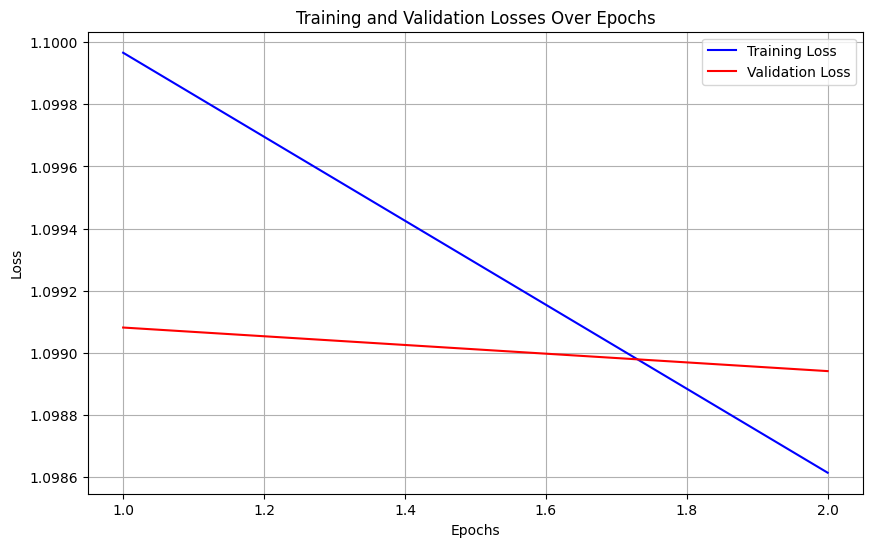

Testing:   2%|▏         | 1/50 [00:00<00:39,  1.23it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Testing:   4%|▍         | 2/50 [00:01<00:41,  1.15it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0


Testing:   6%|▌         | 3/50 [00:02<00:40,  1.16it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Testing:   8%|▊         | 4/50 [00:03<00:39,  1.17it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Testing:  10%|█         | 5/50 [00:04<00:37,  1.20it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Testing:  12%|█▏        | 6/50 [00:05<00:36,  1.22it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Testing:  14%|█▍        | 7/50 [00:05<00:35,  1.20it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Testing:  16%|█▌        | 8/50 [00:06<00:35,  1.20it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Testing:  18%|█▊        | 9/50 [00:07<00:33,  1.22it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Testing:  20%|██        | 10/50 [00:08<00:32,  1.23it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Testing:  22%|██▏       | 11/50 [00:09<00:31,  1.25it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Testing:  24%|██▍       | 12/50 [00:09<00:30,  1.23it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Testing:  26%|██▌       | 13/50 [00:10<00:30,  1.23it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Testing:  28%|██▊       | 14/50 [00:11<00:29,  1.20it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Testing:  30%|███       | 15/50 [00:12<00:29,  1.21it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Testing:  32%|███▏      | 16/50 [00:13<00:27,  1.22it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Testing:  34%|███▍      | 17/50 [00:14<00:27,  1.21it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Testing:  36%|███▌      | 18/50 [00:14<00:26,  1.21it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Testing:  38%|███▊      | 19/50 [00:15<00:25,  1.20it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Testing:  40%|████      | 20/50 [00:16<00:25,  1.20it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Testing:  42%|████▏     | 21/50 [00:17<00:24,  1.20it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Testing:  44%|████▍     | 22/50 [00:18<00:24,  1.12it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Testing:  46%|████▌     | 23/50 [00:19<00:25,  1.05it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Testing:  48%|████▊     | 24/50 [00:20<00:24,  1.07it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Testing:  50%|█████     | 25/50 [00:21<00:22,  1.12it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Testing:  52%|█████▏    | 26/50 [00:22<00:21,  1.13it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Testing:  54%|█████▍    | 27/50 [00:22<00:19,  1.16it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0


Testing:  56%|█████▌    | 28/50 [00:23<00:18,  1.18it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0


Testing:  58%|█████▊    | 29/50 [00:24<00:17,  1.18it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Testing:  60%|██████    | 30/50 [00:25<00:16,  1.19it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Testing:  62%|██████▏   | 31/50 [00:26<00:16,  1.18it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Testing:  64%|██████▍   | 32/50 [00:27<00:15,  1.18it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Testing:  66%|██████▌   | 33/50 [00:27<00:14,  1.21it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Testing:  68%|██████▊   | 34/50 [00:28<00:13,  1.21it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0


Testing:  70%|███████   | 35/50 [00:29<00:12,  1.23it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Testing:  72%|███████▏  | 36/50 [00:30<00:11,  1.21it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Testing:  74%|███████▍  | 37/50 [00:31<00:10,  1.20it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Testing:  76%|███████▌  | 38/50 [00:32<00:10,  1.19it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Testing:  78%|███████▊  | 39/50 [00:32<00:09,  1.18it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Testing:  80%|████████  | 40/50 [00:33<00:08,  1.20it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Testing:  82%|████████▏ | 41/50 [00:34<00:07,  1.21it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1


Testing:  84%|████████▍ | 42/50 [00:35<00:06,  1.22it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1


Testing:  86%|████████▌ | 43/50 [00:36<00:05,  1.21it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Testing:  88%|████████▊ | 44/50 [00:36<00:04,  1.22it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2


Testing:  90%|█████████ | 45/50 [00:37<00:04,  1.18it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Testing:  92%|█████████▏| 46/50 [00:38<00:03,  1.17it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2


Testing:  94%|█████████▍| 47/50 [00:39<00:02,  1.14it/s]

Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0


Testing:  96%|█████████▌| 48/50 [00:40<00:01,  1.12it/s]

Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1


Testing:  98%|█████████▊| 49/50 [00:41<00:00,  1.15it/s]

Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2


Predicted: 2, Actual: 1
Predicted: 2, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 0
Predicted: 2, Actual: 0
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 2, Actual: 1
Predicted: 2, Actual: 0
Predicted: 2, Actual: 1
Test Accuracy: 0.3333
Test Class Distribution: [250, 250, 250]


In [194]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
model = SimpleCNN(num_classes=3).to(device)

# Training parameters
num_epochs = 2 # Adjust as needed
class_weights = torch.tensor([1.0, 1.0, 1.0]).to(device)  # Update these based on your class distribution
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Adjust learning rate if needed
# **Add the learning rate scheduler here**
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Decrease LR every 10 epochs by a factor of 0.1

best_val_accuracy = 0.0  # Track the best validation accuracy to save the best model

# Store losses for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    class_counts = [0] * 3  # Assuming 3 classes, update if needed

    # Training phase with tqdm progress bar
    for images, labels, _ in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Update class counts
        for label in labels:
            class_counts[label.item()] += 1
        
        # Print predicted vs actual labels for each batch
        for i in range(len(labels)):
            print(f"Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")
    
    # Print class distribution during training
    print(f"Training Class Distribution: {class_counts}")
    
    # **Call the scheduler here at the end of each epoch to update the learning rate**
    scheduler.step()

    # Store training loss for plotting
    train_losses.append(epoch_loss)

    # Validation phase with tqdm progress bar
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0
    val_class_counts = [0] * 3  # Assuming 3 classes, update if needed

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels, _ in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track validation loss and accuracy
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_samples += labels.size(0)

            # Update class counts for validation
            for label in labels:
                val_class_counts[label.item()] += 1

            # Print predicted vs actual labels for each batch
            for i in range(len(labels)):
                print(f"Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")

    val_epoch_loss = val_loss / val_total_samples
    val_epoch_accuracy = val_correct_predictions / val_total_samples
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")
    
    # Print class distribution during validation
    print(f"Validation Class Distribution: {val_class_counts}")

    # Store validation loss for plotting
    val_losses.append(val_epoch_loss)

    # Save the model if it achieves better validation accuracy
    if val_epoch_accuracy > best_val_accuracy:
        best_val_accuracy = val_epoch_accuracy
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        print("Saved the model with improved validation accuracy.")

# End of training loop
print("Training complete.")

# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Test model function with tqdm progress bar
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    test_class_counts = [0] * 3  # Assuming 3 classes, update if needed
    with torch.no_grad():  # Disable gradients for testing
        for images, labels, _ in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Update class counts for testing
            for label in labels:
                test_class_counts[label.item()] += 1

            # Print predicted vs actual labels for each batch
            for i in range(len(labels)):
                print(f"Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")

    avg_accuracy = correct_predictions / total_samples
    print(f"Test Accuracy: {avg_accuracy:.4f}")
    
    # Print class distribution during testing
    print(f"Test Class Distribution: {test_class_counts}")

# Run the test phase after training
test_model(model, test_loader)